In [23]:
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

<IPython.core.display.Javascript object>

# create U-shape env

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from utils.plot import plot_edges
import numpy as np
from environment import MazeEnv
from str2env import str2env

env, indexes = str2env('maze2hard')
env.maps = env.maps.tolist()
def create_simple_map(width=15):
    map_ = np.ones((width, width))
    map_[1:-1,1:-1] = 0
    map_[int(width*(9/15)), int(width*(4/15)):int(width*(13/15))] = 1
    map_[int(width*(6/15)), int(width*(4/15)):int(width*(13/15))] = 1
    map_[int(width*(6/15)):int(width*(9/15)+1), int(width*(4/15))] = 1
    return map_

# env.map[11, 4:10] = 1

# env.map[3, 4:10] = 1
# env.map[3:12, 10] = 1
# env.map[3:12, 9] = 1

<Figure size 432x288 with 0 Axes>

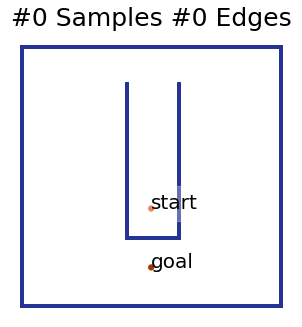

In [45]:
map_ = create_simple_map(100)
env.maps[0] = map_
env.init_new_problem(0)
env.goal_state = np.array([-0.,  0-0.7])
env.init_state = np.array([-0.,  0-0.25])
plot_edges({}, {}, env.get_problem())
plt.show()

In [40]:
def plan_sp(env):
    set_random_seed(seed)
    lazysp = LazySP(env, batch_size=100, T=100)
    result_sp = lazysp.plan()
    return result_sp

def plan_gnn(env):
    set_random_seed(seed)
    _, model, model_path, _, _ = str2name('maze2hard')
    model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
    _, _, _, model_s, model_s_path = str2name('maze2hard')
    model_s.load_state_dict(torch.load(model_s_path, map_location=torch.device("cpu")))
    model.eval()
    model_s.eval()
    result = explore(env, model, model_s, smooth=True, batch=100, t_max=100, k=10, loop=10) 
    return result

In [8]:
def plot(result_sp, result_gnn, env):
    result_sps = [result_sp]
    i = 0
    plot_edges(result_sps[i][0], [[result_sps[i][0][k], result_sps[i][0][v]] for set_ in [result_sps[i][5], result_sps[i][6]] for k, v in set_ ], \
               env.get_problem(), title='Maze Thinness {0:d}\nLazySP explores {2:d} edges\nCollision Check {1:d}'.format(env.width, result_sp[1], len(result_sps[i][5] | result_sps[i][6])//2),
              save='data/images/{0:d}_{1:d}_lazy.png'.format(seed, env.width))
    plt.show()
    result_gnns = [result_gnn]
    i = 0
    edges = result_gnns[i]['data'].v[np.array(result_gnns[i]['explored_edges']).reshape(-1)].reshape(-1, 2, 2)
    edges = [[tuple(k), tuple(v)] for k, v in zip(edges[:, 0, :].cpu().numpy(), edges[:, 1, :].cpu().numpy())]
    plot_edges(result_gnns[i]['data'].v.data.cpu().numpy(), edges, env.get_problem(), \
               title='Maze Thinness {0:d}\nGNN explores {2:d} edges\nCollision Check {1:d}'.format(env.width, result_gnn['c_explore'], (len(result_gnns[i]['explored_edges'])-1)//2),
               save='data/images/{0:d}_{1:d}_gnn.png'.format(seed, env.width))
    plt.show()

In [ ]:
from algorithm.lazy_sp import LazySP
from config import set_random_seed
from eval_gnn import explore
from str2name import str2name
import torch

thinnesses = [9, 13, 17, 21, 25, 29, 31, 35, 39, 43]

for seed in [1234, 2341, 3412, 4123]:
    for width in thinnesses:
        seed_ = seed
        env.maps[0] = create_simple_map(width=width)
        env.init_new_problem(0)
        env.goal_state = np.array([-0.,  0-0.7])
        env.init_state = np.array([-0.,  0-0.25])
        plot_edges({}, {}, env.get_problem())

        while True:
            seed = np.random.randint(100)
            result_sp = plan_sp(env)
            result_gnn = plan_gnn(env)
            print('width {0:d}, gnn collision {1:d}, lazy collision {2:d}'.format(width, result_gnn['c_explore'], result_sp[1]))
            seed = seed_
            plot(result_sp, result_gnn, env)
            plt.clf()
            if len(result_sp[2])!=0:
                break

In [4]:
from PIL import Image
def merge_pic(image_paths, column, row, save_path):
    images = [Image.open(x) for x in image_paths]
    widths, heights = zip(*(i.size for i in images))

    total_width = column * max(widths)
    total_height = row * max(heights)

    new_im = Image.new('RGB', (total_width, total_height), (256, 256, 256))

    index = 0
    for i in range(row):
        for j in range(column):
            new_im.paste(images[index], (j * max(widths), i * max(heights)))
#             new_im.paste(images[index], (j * (max(widths)), i * (max(heights))))
            index += 1

    new_im.save(save_path)

In [5]:
for seed in [1234, 2341, 3412, 4123]:
    image_paths = ['data/images/{0:d}_{1:d}_{2:s}.png'.format(seed, width, method) for width in thinnesses for method in ['lazy', 'gnn']]
    merge_pic(image_paths, 2, len(image_paths)//2, 'data/images/random_lazy_gnn_{0:d}.png'.format(seed))
merge_pic(['data/images/random_lazy_gnn_{0:d}.png'.format(seed) for seed in [1234, 2341, 3412, 4123]], 4, 1, 'data/images/narrow_deep.png')    

NameError: name 'thinnesses' is not defined

# generate U-shape data

In [36]:
def create_simple_map(bottom, depth, narrow, env, width=15):
    map_ = np.ones((width, width))
    assert 2<=bottom<=(width-3)
    assert 1<=narrow<=(width//2)-2
    assert 0<=depth<=(width-3-bottom)
    map_[1:-1,1:-1] = 0
    map_[int(width*0.5)+narrow, bottom:(bottom+depth+1)] = 1
    map_[int(width*0.5)-narrow, bottom:(bottom+depth+1)] = 1
    map_[(int(width*0.5)-narrow):(int(width*0.5)+narrow+1), bottom] = 1
    start = (0., env._inverse_transform((bottom+1, width//2), width)[0]+0.5/width)
    goal = (0., env._inverse_transform((bottom-1, width//2), width)[0]+0.5/width)
    return map_, start, goal

<Figure size 432x288 with 0 Axes>

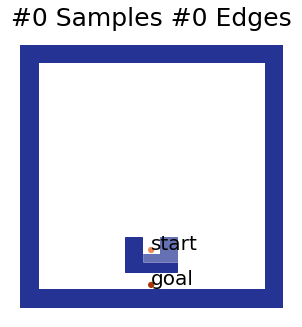

<Figure size 432x288 with 0 Axes>

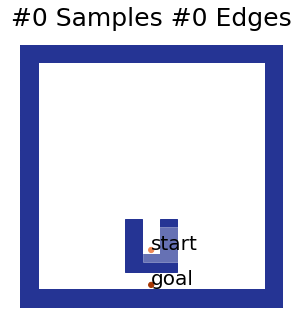

<Figure size 432x288 with 0 Axes>

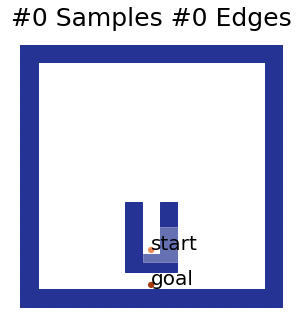

<Figure size 432x288 with 0 Axes>

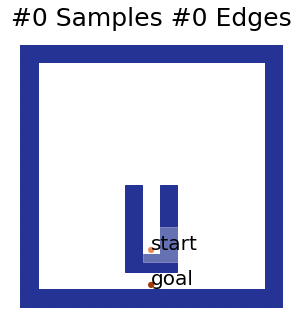

<Figure size 432x288 with 0 Axes>

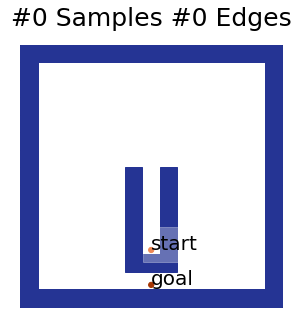

<Figure size 432x288 with 0 Axes>

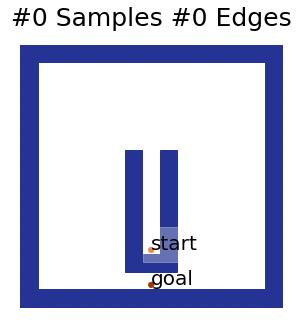

<Figure size 432x288 with 0 Axes>

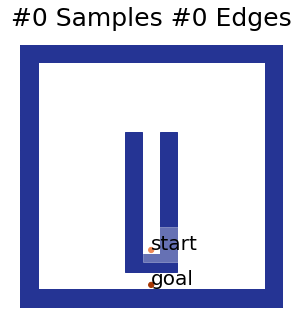

<Figure size 432x288 with 0 Axes>

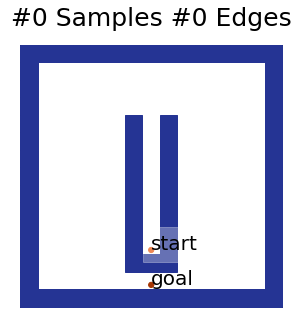

<Figure size 432x288 with 0 Axes>

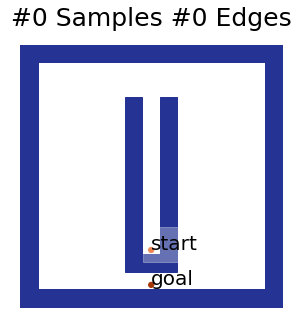

<Figure size 432x288 with 0 Axes>

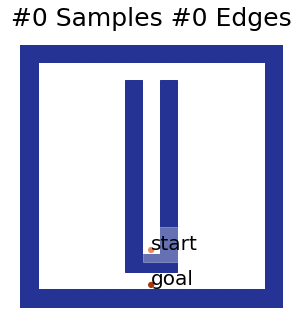

<Figure size 432x288 with 0 Axes>

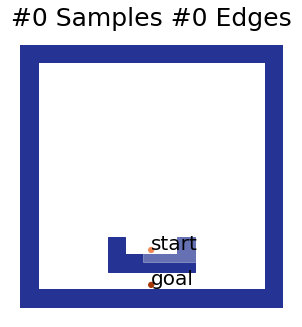

<Figure size 432x288 with 0 Axes>

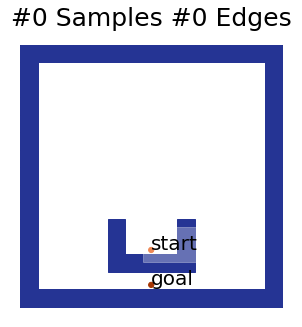

<Figure size 432x288 with 0 Axes>

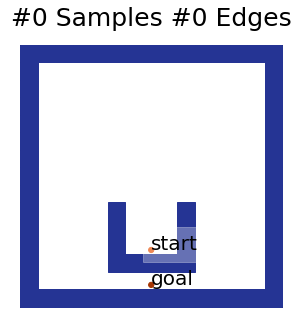

<Figure size 432x288 with 0 Axes>

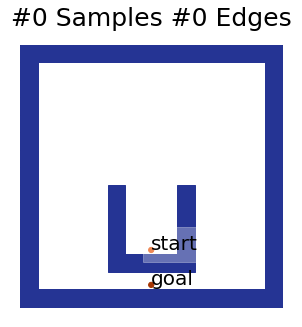

<Figure size 432x288 with 0 Axes>

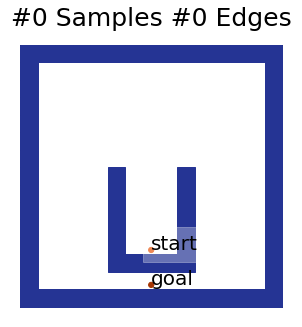

<Figure size 432x288 with 0 Axes>

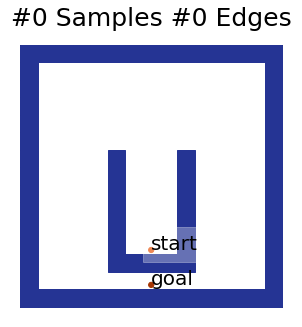

<Figure size 432x288 with 0 Axes>

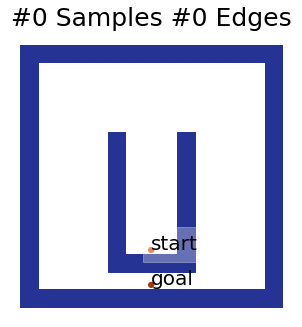

<Figure size 432x288 with 0 Axes>

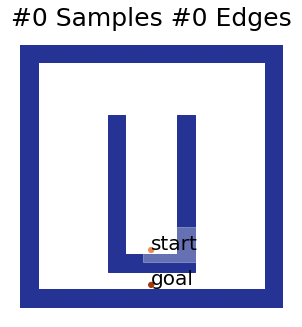

<Figure size 432x288 with 0 Axes>

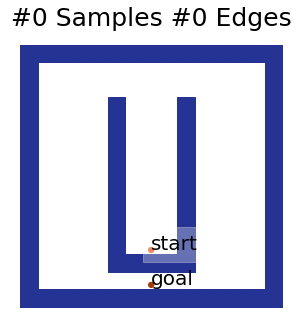

<Figure size 432x288 with 0 Axes>

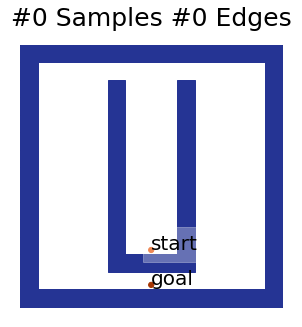

<Figure size 432x288 with 0 Axes>

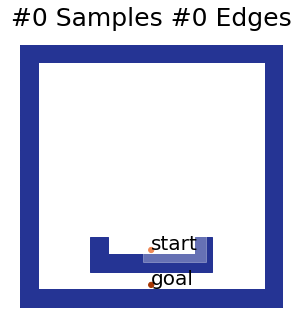

<Figure size 432x288 with 0 Axes>

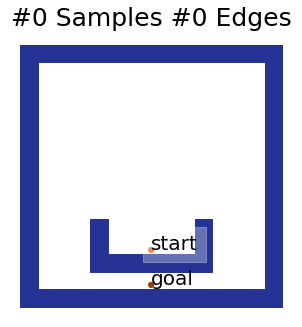

<Figure size 432x288 with 0 Axes>

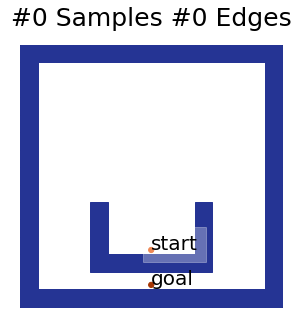

<Figure size 432x288 with 0 Axes>

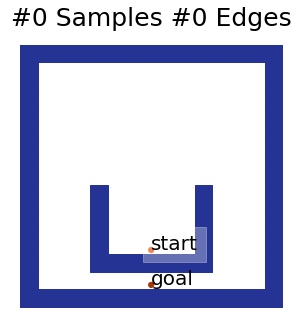

<Figure size 432x288 with 0 Axes>

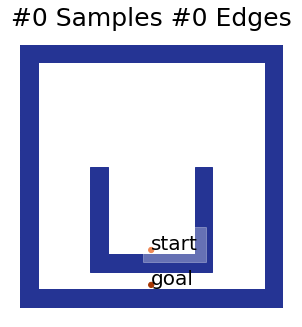

<Figure size 432x288 with 0 Axes>

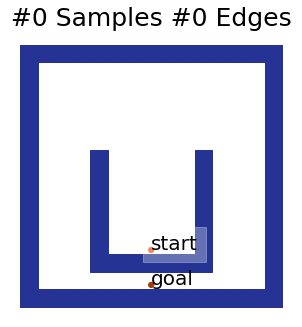

<Figure size 432x288 with 0 Axes>

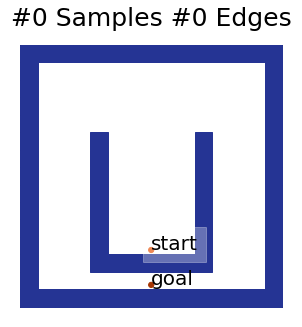

<Figure size 432x288 with 0 Axes>

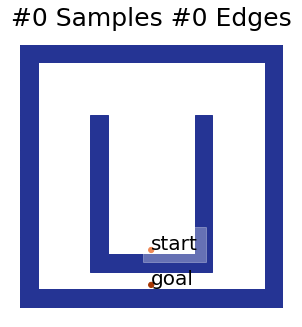

<Figure size 432x288 with 0 Axes>

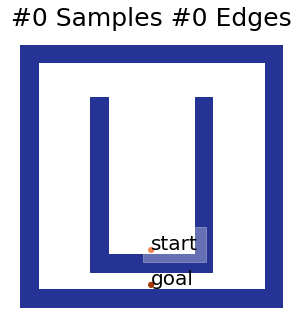

<Figure size 432x288 with 0 Axes>

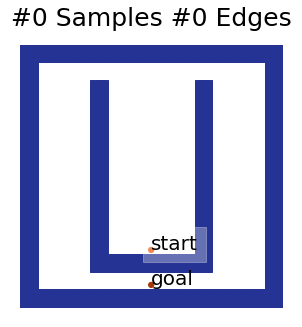

<Figure size 432x288 with 0 Axes>

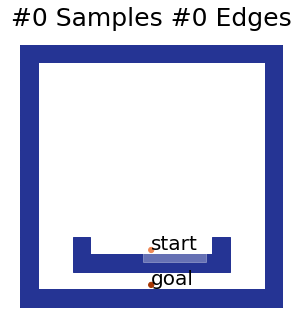

<Figure size 432x288 with 0 Axes>

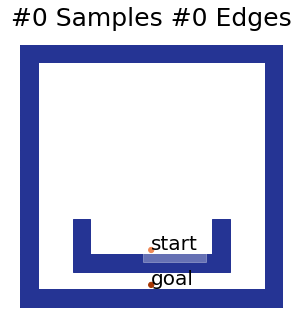

<Figure size 432x288 with 0 Axes>

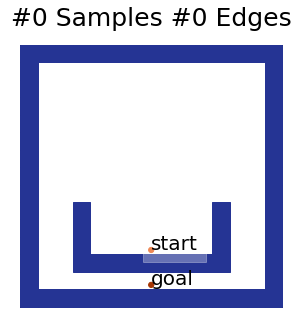

<Figure size 432x288 with 0 Axes>

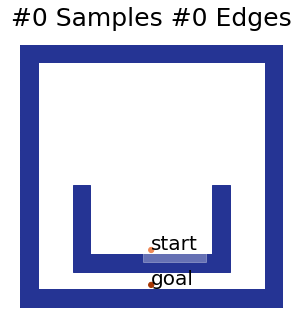

<Figure size 432x288 with 0 Axes>

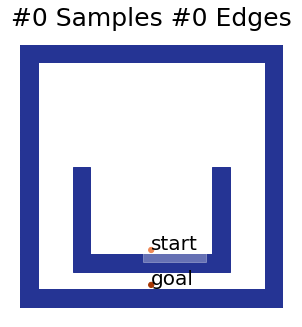

<Figure size 432x288 with 0 Axes>

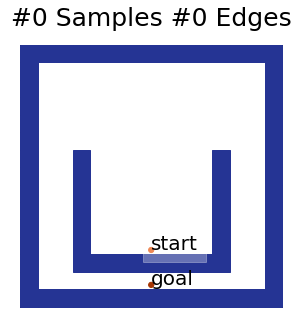

<Figure size 432x288 with 0 Axes>

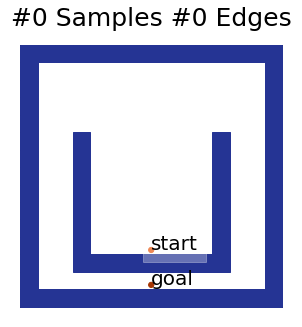

<Figure size 432x288 with 0 Axes>

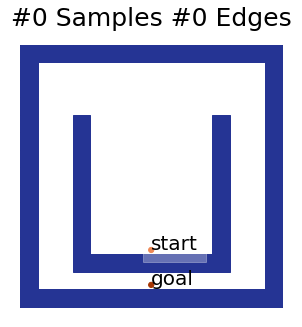

<Figure size 432x288 with 0 Axes>

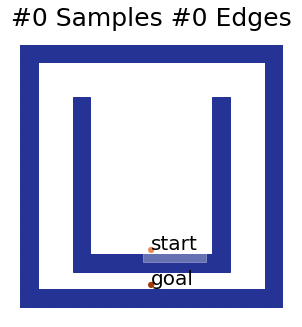

<Figure size 432x288 with 0 Axes>

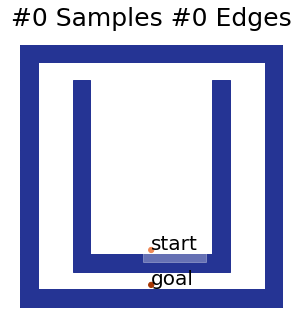

<Figure size 432x288 with 0 Axes>

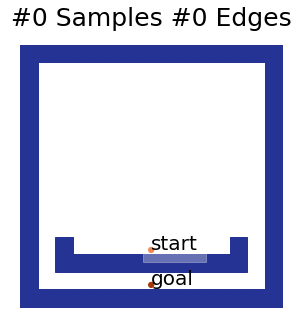

<Figure size 432x288 with 0 Axes>

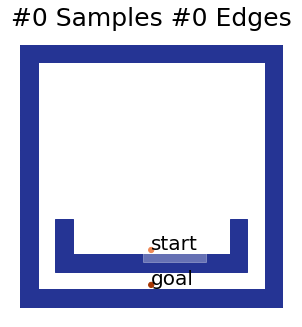

<Figure size 432x288 with 0 Axes>

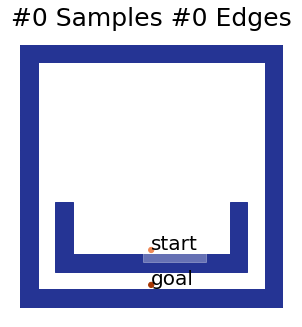

<Figure size 432x288 with 0 Axes>

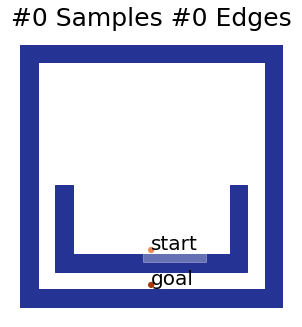

<Figure size 432x288 with 0 Axes>

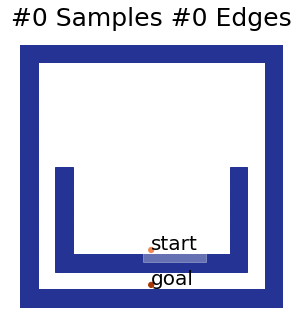

<Figure size 432x288 with 0 Axes>

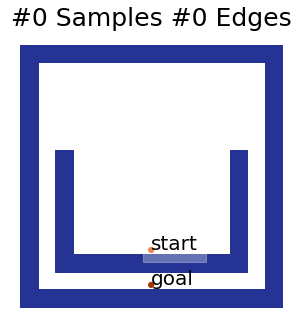

<Figure size 432x288 with 0 Axes>

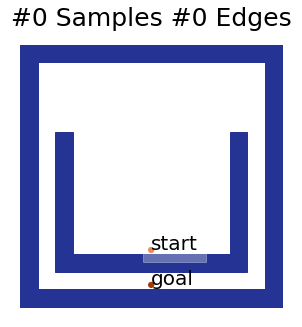

<Figure size 432x288 with 0 Axes>

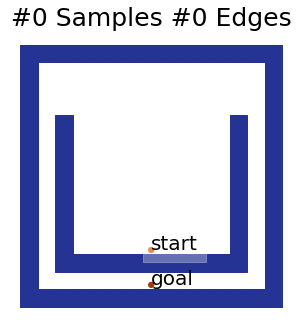

<Figure size 432x288 with 0 Axes>

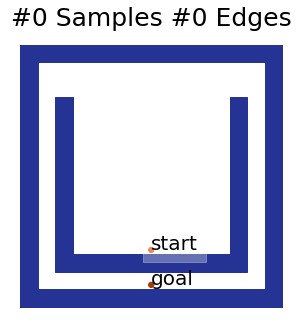

<Figure size 432x288 with 0 Axes>

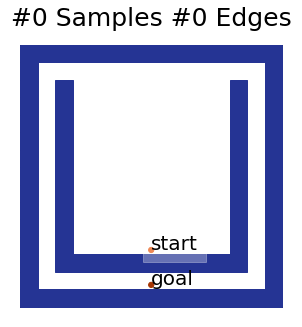

<Figure size 432x288 with 0 Axes>

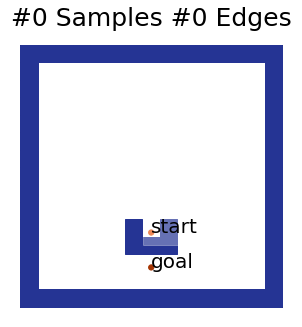

<Figure size 432x288 with 0 Axes>

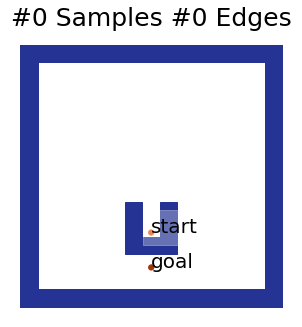

<Figure size 432x288 with 0 Axes>

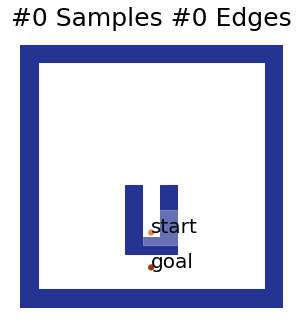

<Figure size 432x288 with 0 Axes>

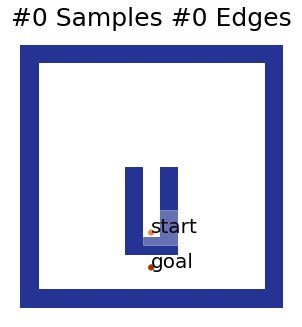

<Figure size 432x288 with 0 Axes>

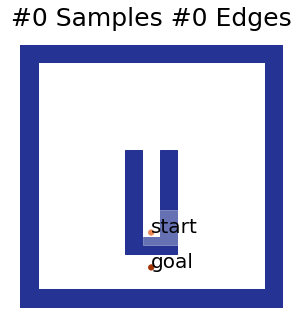

<Figure size 432x288 with 0 Axes>

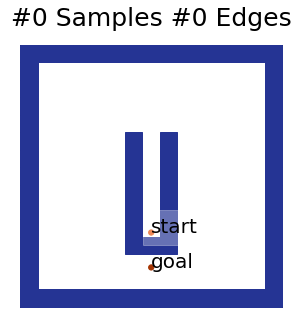

<Figure size 432x288 with 0 Axes>

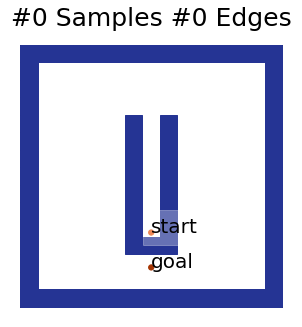

<Figure size 432x288 with 0 Axes>

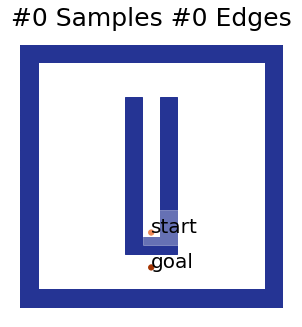

<Figure size 432x288 with 0 Axes>

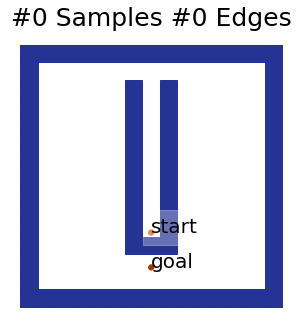

<Figure size 432x288 with 0 Axes>

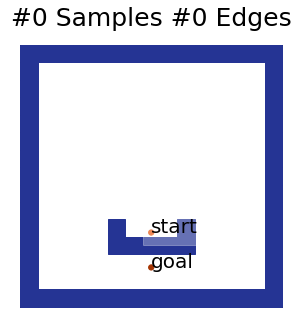

<Figure size 432x288 with 0 Axes>

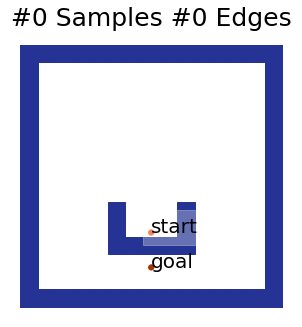

<Figure size 432x288 with 0 Axes>

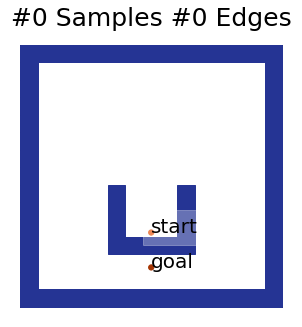

<Figure size 432x288 with 0 Axes>

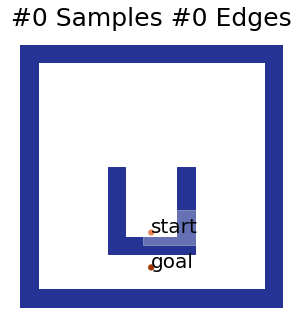

<Figure size 432x288 with 0 Axes>

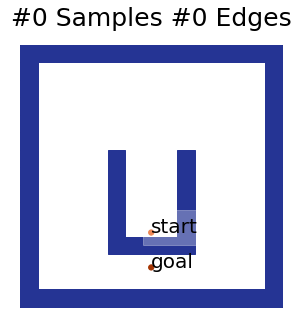

<Figure size 432x288 with 0 Axes>

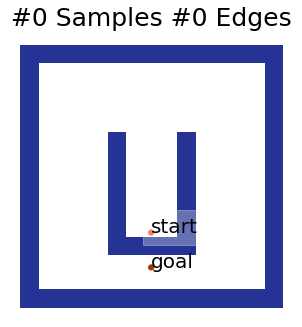

<Figure size 432x288 with 0 Axes>

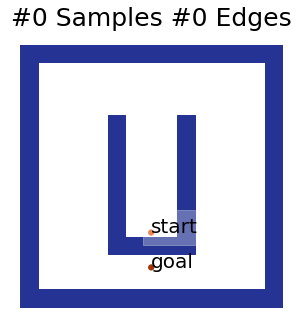

<Figure size 432x288 with 0 Axes>

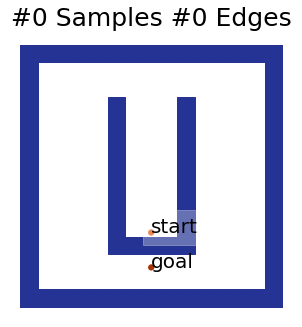

<Figure size 432x288 with 0 Axes>

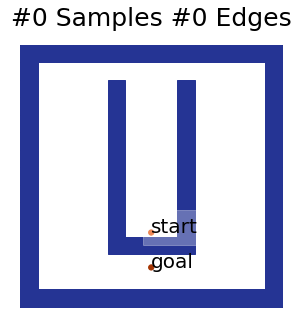

<Figure size 432x288 with 0 Axes>

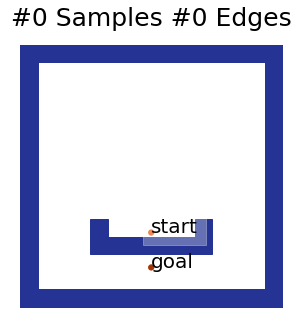

<Figure size 432x288 with 0 Axes>

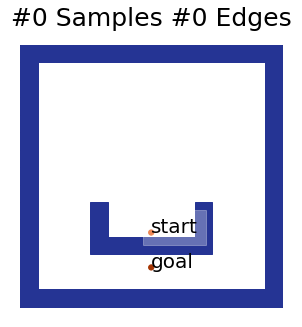

<Figure size 432x288 with 0 Axes>

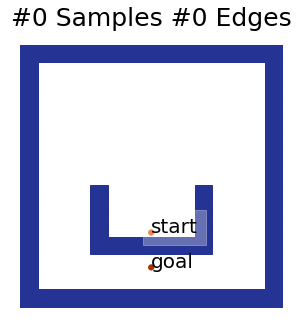

<Figure size 432x288 with 0 Axes>

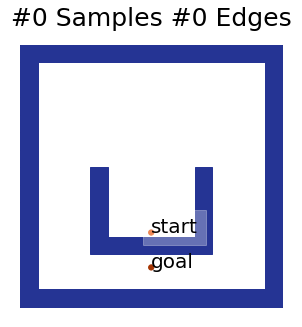

<Figure size 432x288 with 0 Axes>

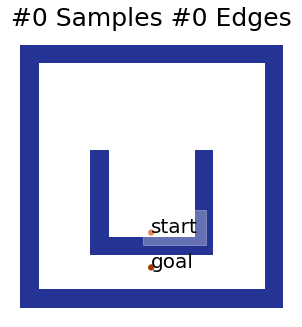

<Figure size 432x288 with 0 Axes>

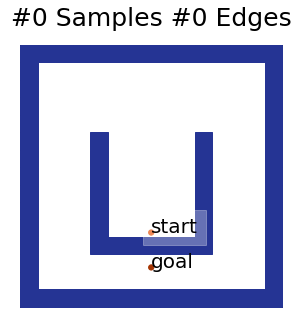

<Figure size 432x288 with 0 Axes>

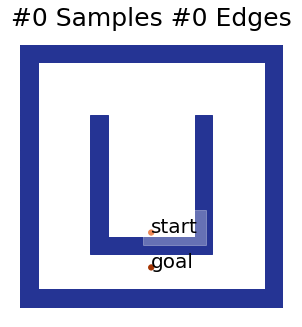

<Figure size 432x288 with 0 Axes>

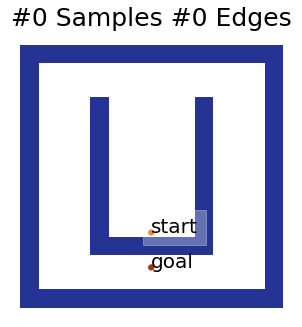

<Figure size 432x288 with 0 Axes>

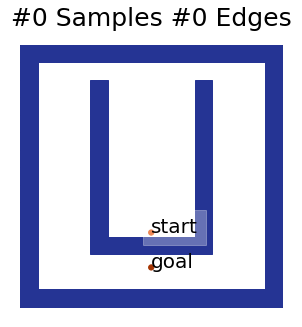

<Figure size 432x288 with 0 Axes>

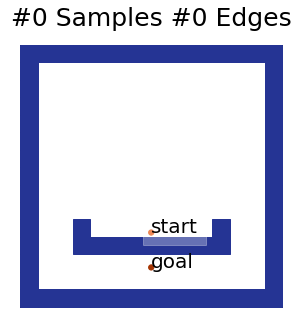

<Figure size 432x288 with 0 Axes>

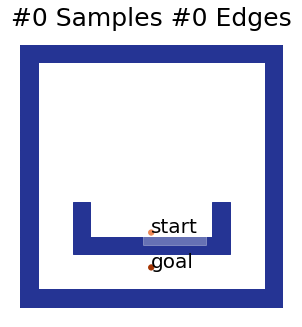

<Figure size 432x288 with 0 Axes>

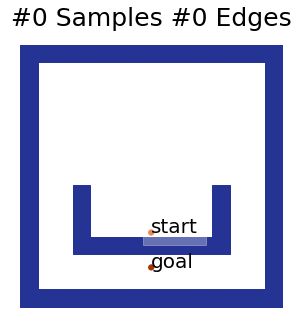

<Figure size 432x288 with 0 Axes>

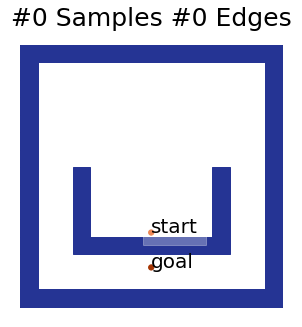

<Figure size 432x288 with 0 Axes>

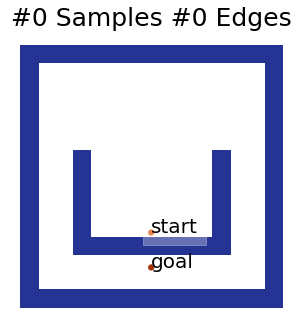

<Figure size 432x288 with 0 Axes>

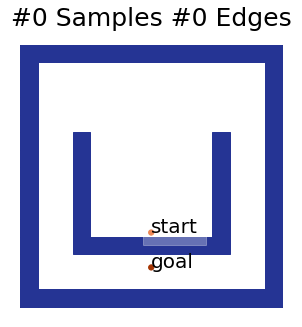

<Figure size 432x288 with 0 Axes>

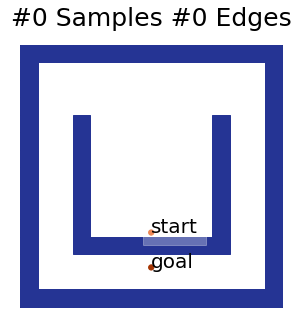

<Figure size 432x288 with 0 Axes>

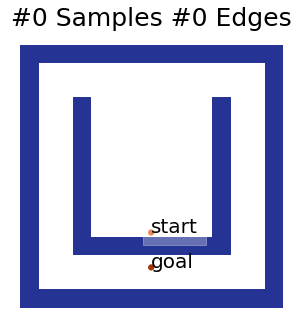

<Figure size 432x288 with 0 Axes>

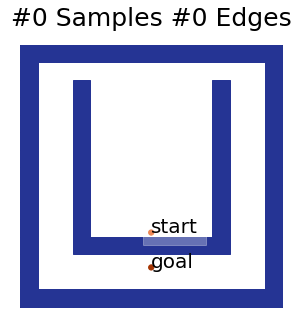

<Figure size 432x288 with 0 Axes>

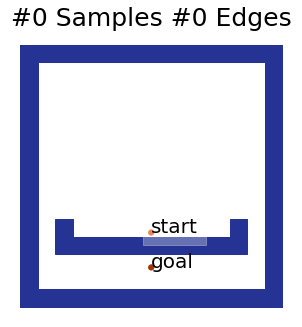

<Figure size 432x288 with 0 Axes>

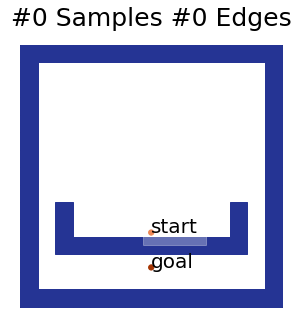

<Figure size 432x288 with 0 Axes>

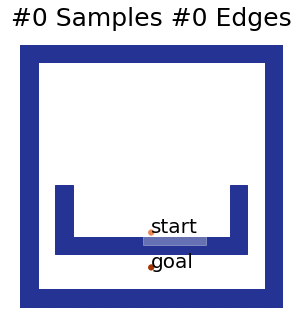

<Figure size 432x288 with 0 Axes>

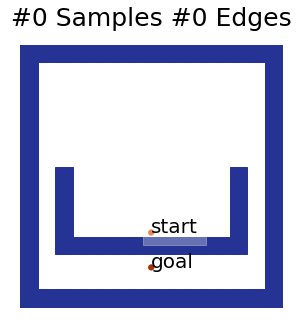

<Figure size 432x288 with 0 Axes>

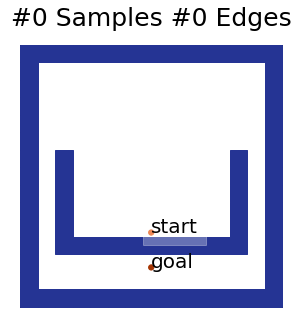

<Figure size 432x288 with 0 Axes>

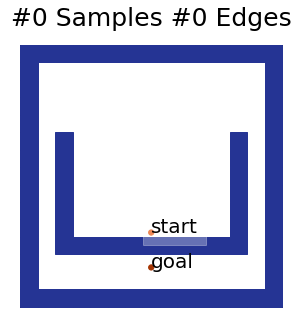

<Figure size 432x288 with 0 Axes>

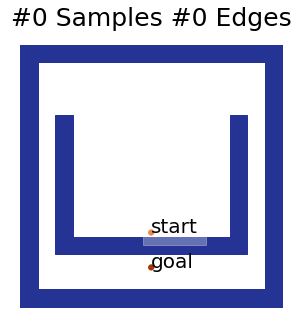

<Figure size 432x288 with 0 Axes>

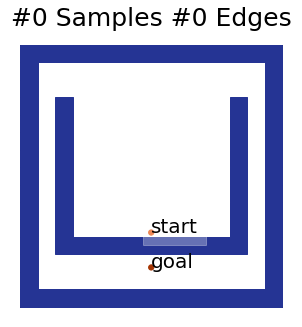

<Figure size 432x288 with 0 Axes>

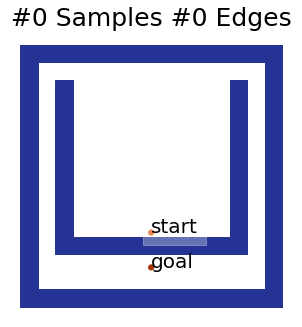

<Figure size 432x288 with 0 Axes>

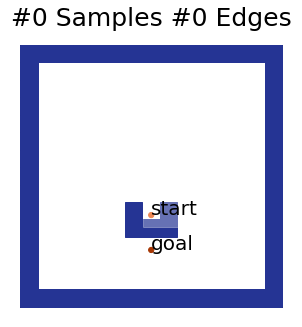

<Figure size 432x288 with 0 Axes>

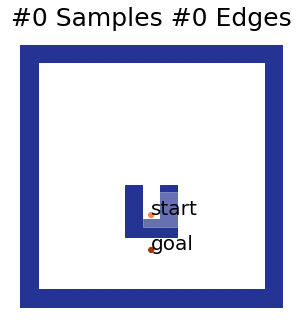

<Figure size 432x288 with 0 Axes>

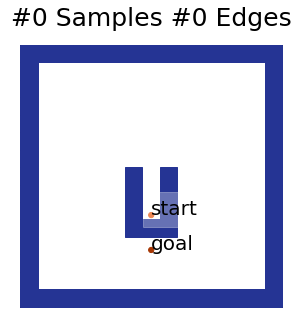

<Figure size 432x288 with 0 Axes>

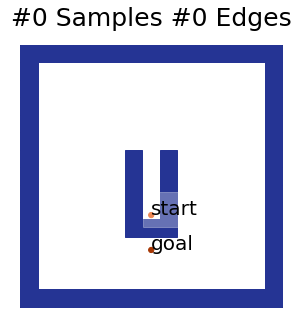

<Figure size 432x288 with 0 Axes>

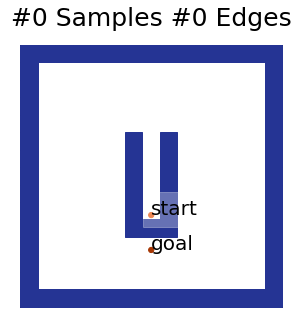

<Figure size 432x288 with 0 Axes>

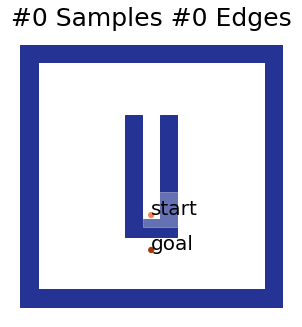

<Figure size 432x288 with 0 Axes>

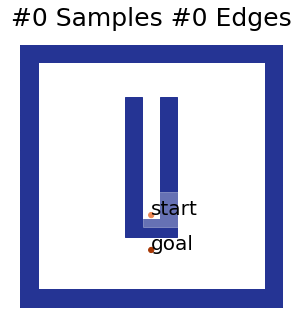

<Figure size 432x288 with 0 Axes>

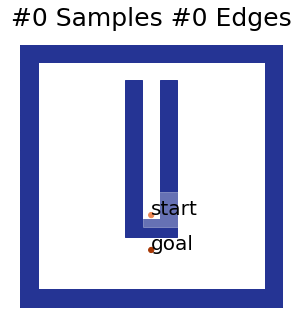

<Figure size 432x288 with 0 Axes>

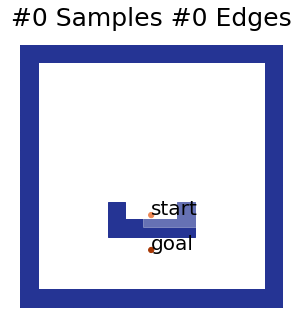

<Figure size 432x288 with 0 Axes>

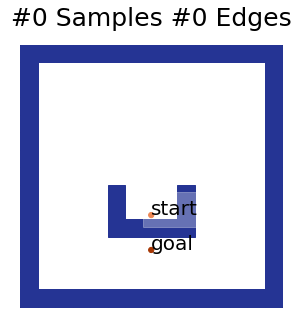

<Figure size 432x288 with 0 Axes>

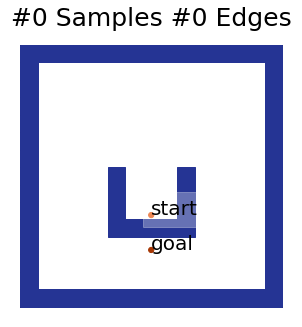

<Figure size 432x288 with 0 Axes>

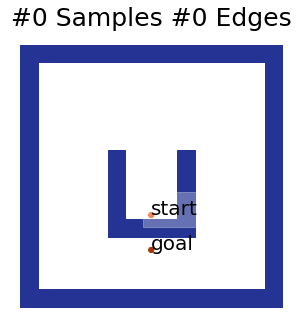

<Figure size 432x288 with 0 Axes>

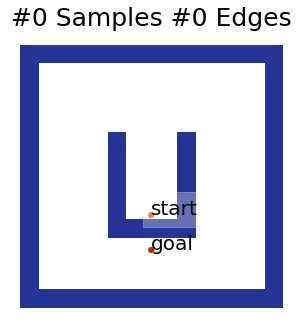

<Figure size 432x288 with 0 Axes>

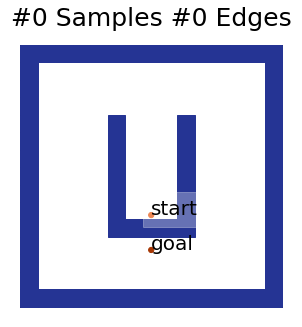

<Figure size 432x288 with 0 Axes>

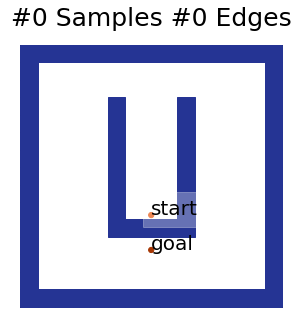

<Figure size 432x288 with 0 Axes>

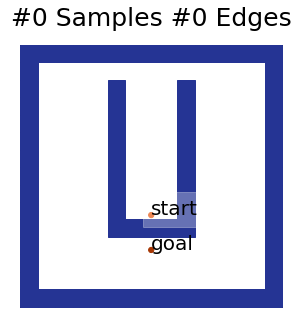

<Figure size 432x288 with 0 Axes>

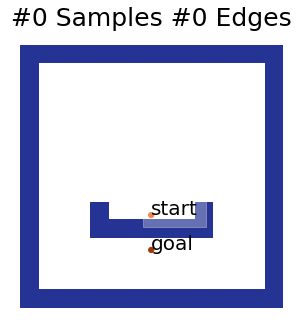

<Figure size 432x288 with 0 Axes>

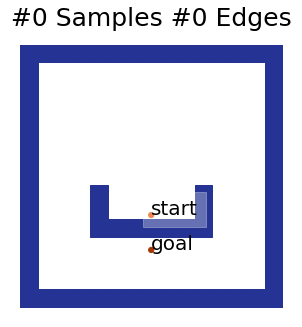

<Figure size 432x288 with 0 Axes>

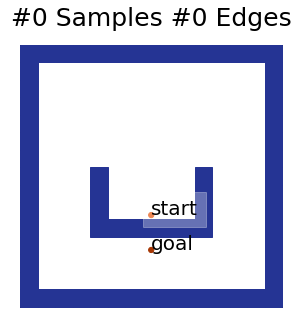

<Figure size 432x288 with 0 Axes>

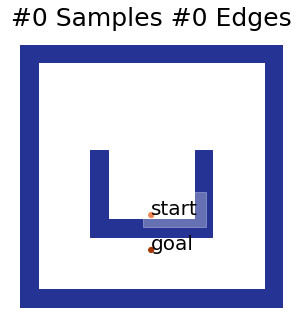

<Figure size 432x288 with 0 Axes>

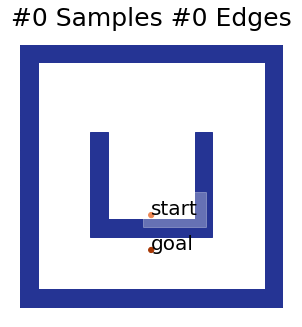

<Figure size 432x288 with 0 Axes>

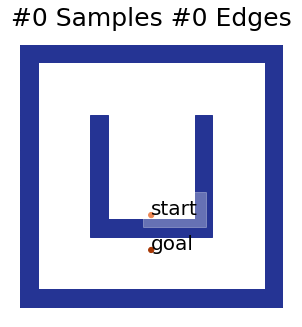

<Figure size 432x288 with 0 Axes>

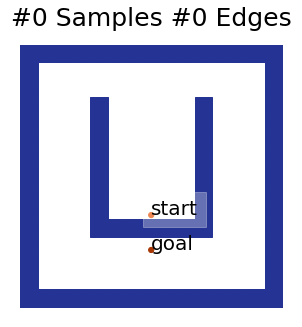

<Figure size 432x288 with 0 Axes>

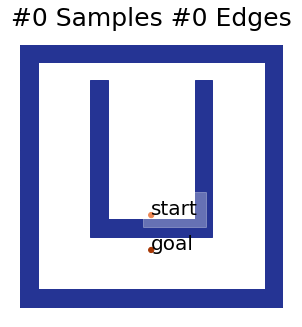

<Figure size 432x288 with 0 Axes>

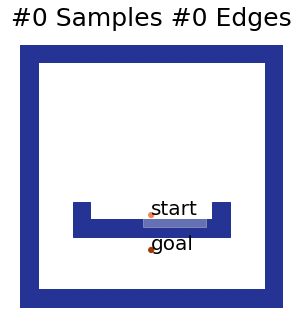

<Figure size 432x288 with 0 Axes>

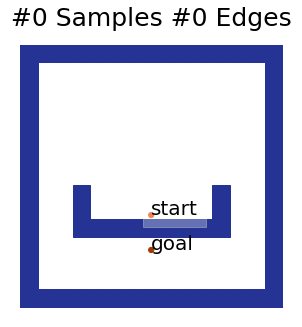

<Figure size 432x288 with 0 Axes>

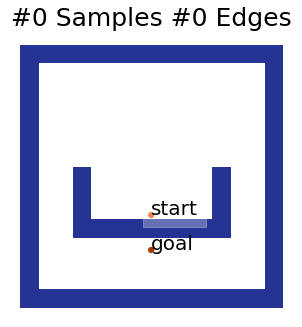

<Figure size 432x288 with 0 Axes>

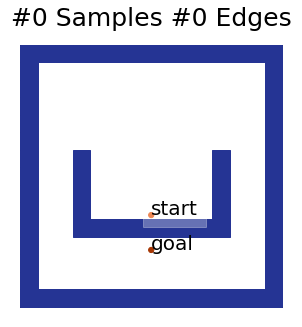

<Figure size 432x288 with 0 Axes>

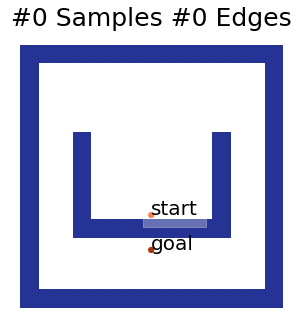

<Figure size 432x288 with 0 Axes>

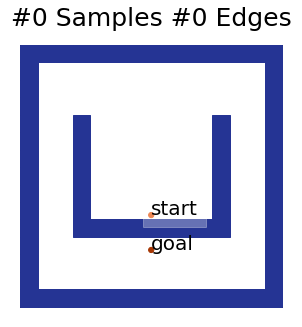

<Figure size 432x288 with 0 Axes>

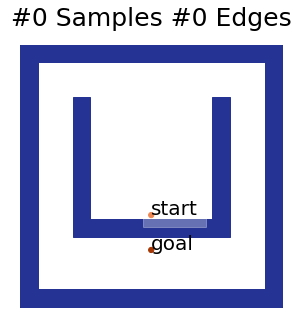

<Figure size 432x288 with 0 Axes>

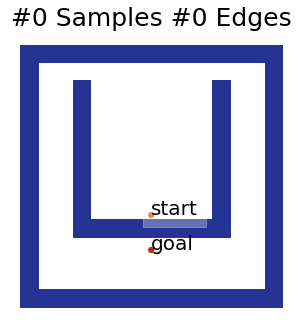

<Figure size 432x288 with 0 Axes>

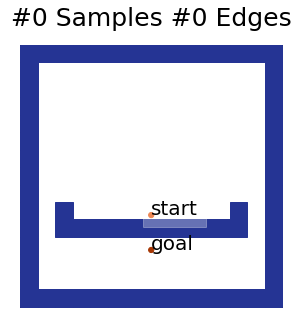

<Figure size 432x288 with 0 Axes>

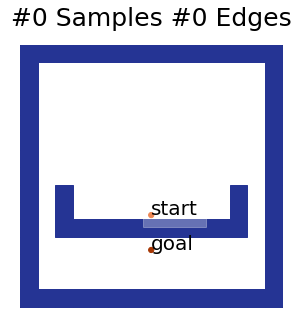

<Figure size 432x288 with 0 Axes>

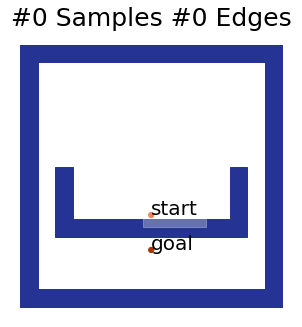

<Figure size 432x288 with 0 Axes>

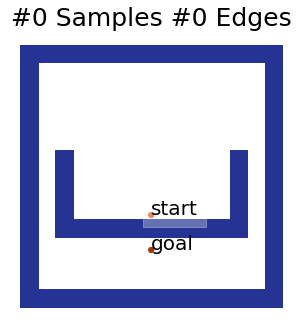

<Figure size 432x288 with 0 Axes>

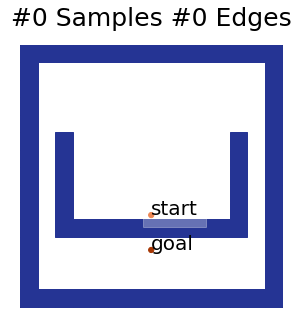

<Figure size 432x288 with 0 Axes>

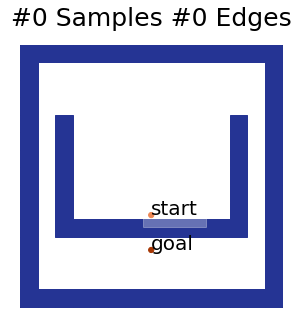

<Figure size 432x288 with 0 Axes>

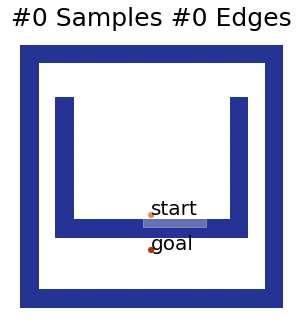

<Figure size 432x288 with 0 Axes>

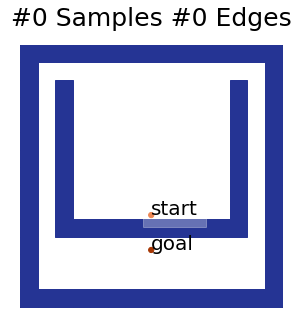

<Figure size 432x288 with 0 Axes>

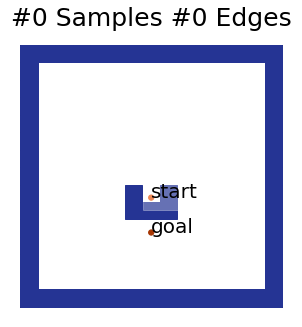

<Figure size 432x288 with 0 Axes>

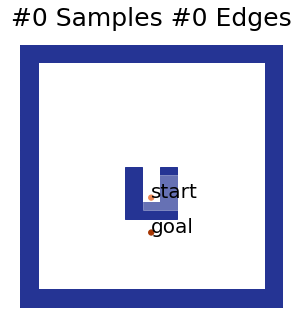

<Figure size 432x288 with 0 Axes>

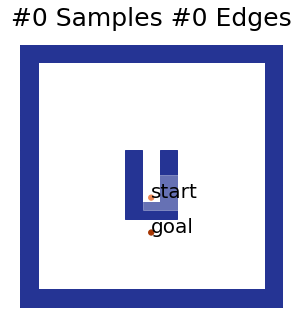

<Figure size 432x288 with 0 Axes>

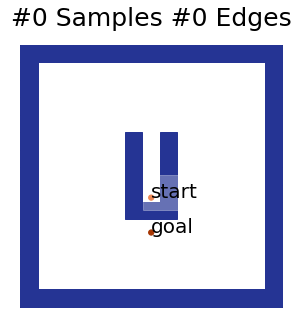

<Figure size 432x288 with 0 Axes>

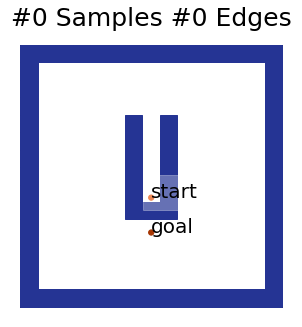

<Figure size 432x288 with 0 Axes>

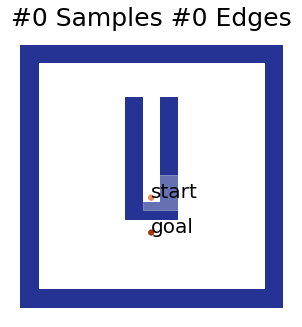

<Figure size 432x288 with 0 Axes>

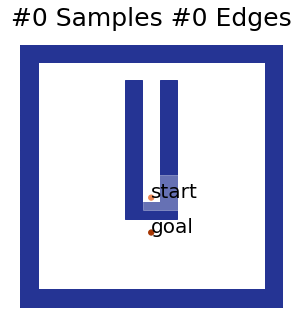

<Figure size 432x288 with 0 Axes>

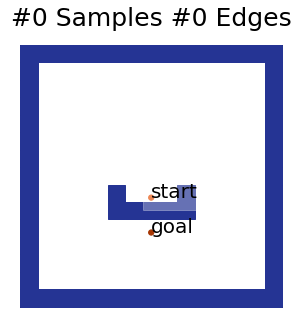

<Figure size 432x288 with 0 Axes>

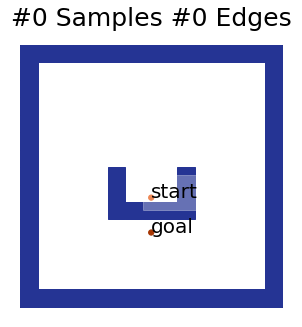

<Figure size 432x288 with 0 Axes>

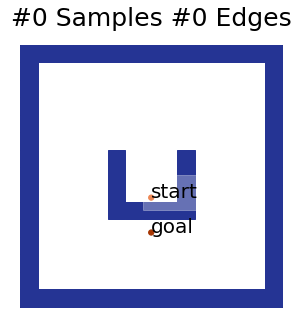

<Figure size 432x288 with 0 Axes>

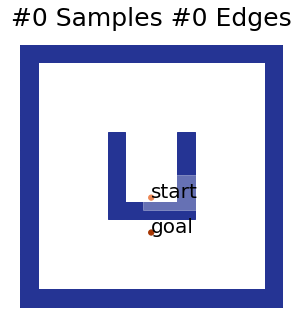

<Figure size 432x288 with 0 Axes>

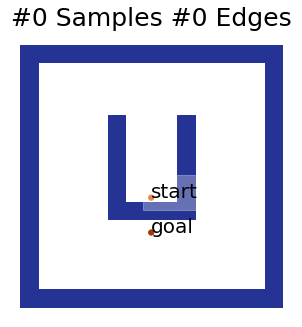

<Figure size 432x288 with 0 Axes>

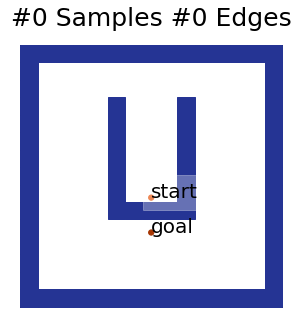

<Figure size 432x288 with 0 Axes>

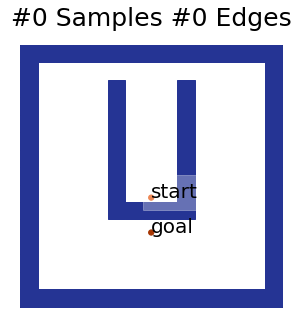

<Figure size 432x288 with 0 Axes>

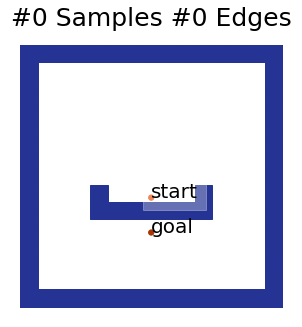

<Figure size 432x288 with 0 Axes>

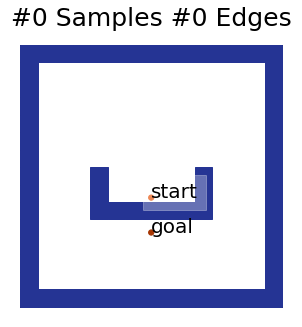

<Figure size 432x288 with 0 Axes>

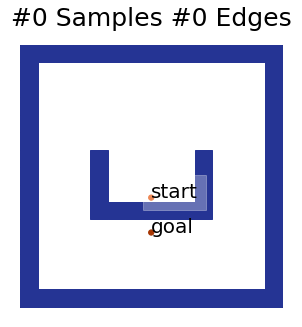

<Figure size 432x288 with 0 Axes>

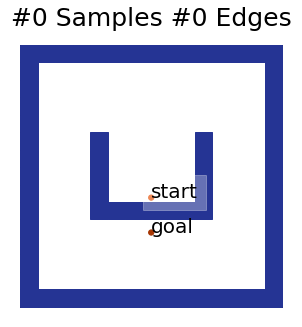

<Figure size 432x288 with 0 Axes>

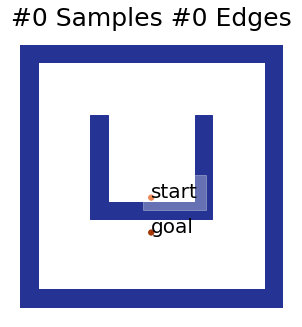

<Figure size 432x288 with 0 Axes>

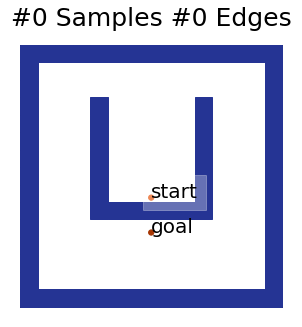

<Figure size 432x288 with 0 Axes>

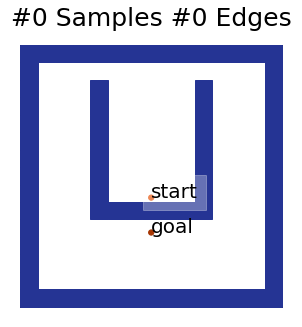

<Figure size 432x288 with 0 Axes>

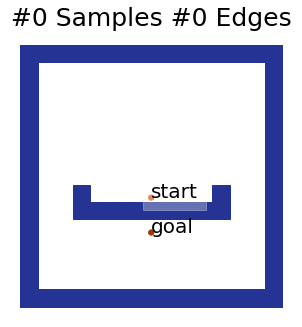

<Figure size 432x288 with 0 Axes>

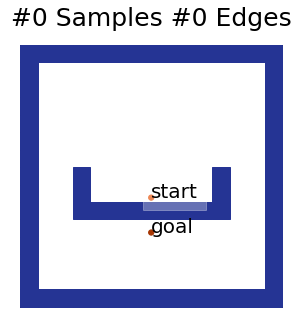

<Figure size 432x288 with 0 Axes>

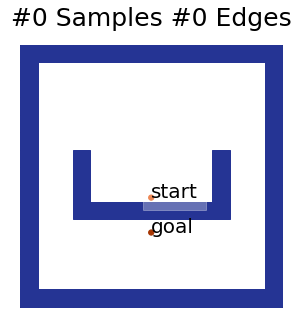

<Figure size 432x288 with 0 Axes>

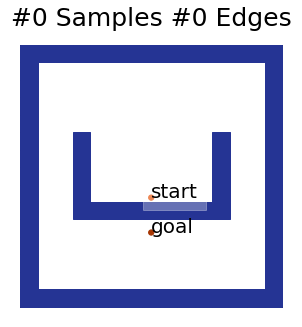

<Figure size 432x288 with 0 Axes>

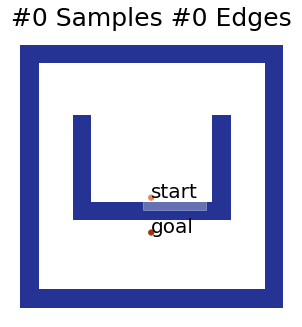

<Figure size 432x288 with 0 Axes>

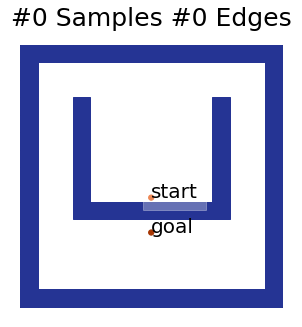

<Figure size 432x288 with 0 Axes>

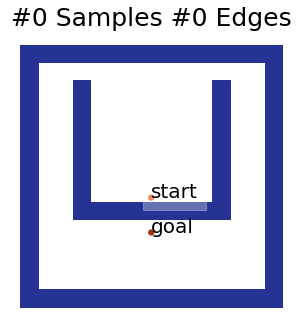

<Figure size 432x288 with 0 Axes>

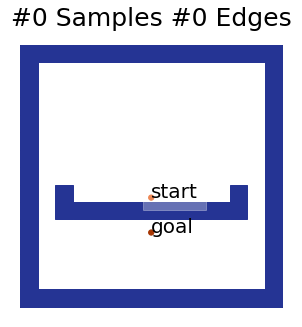

<Figure size 432x288 with 0 Axes>

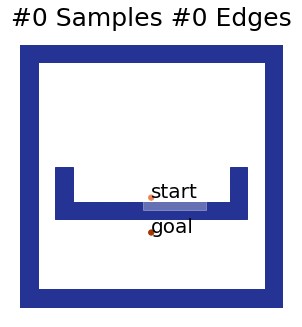

<Figure size 432x288 with 0 Axes>

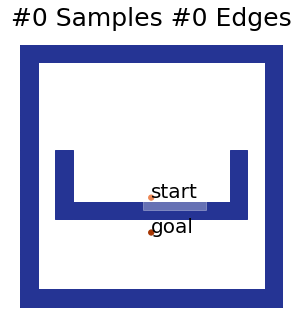

<Figure size 432x288 with 0 Axes>

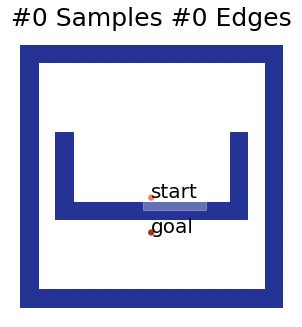

<Figure size 432x288 with 0 Axes>

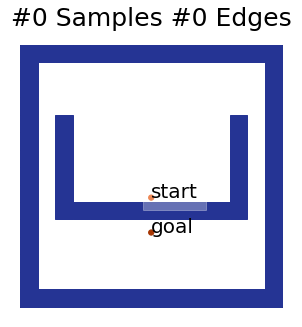

<Figure size 432x288 with 0 Axes>

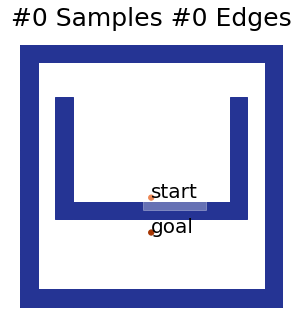

<Figure size 432x288 with 0 Axes>

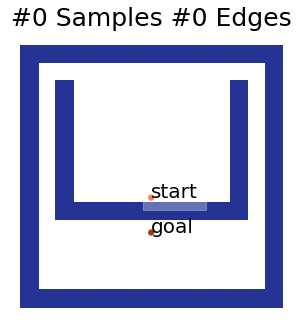

<Figure size 432x288 with 0 Axes>

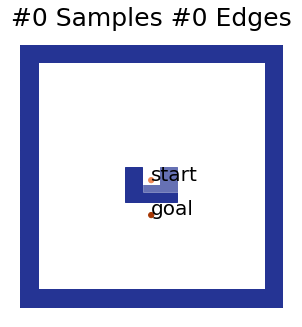

<Figure size 432x288 with 0 Axes>

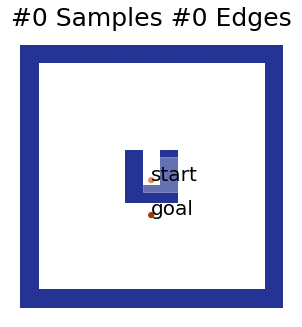

<Figure size 432x288 with 0 Axes>

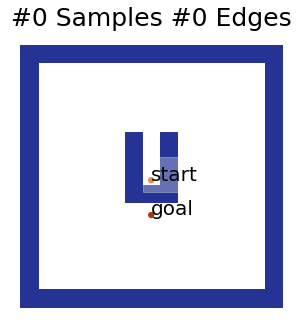

<Figure size 432x288 with 0 Axes>

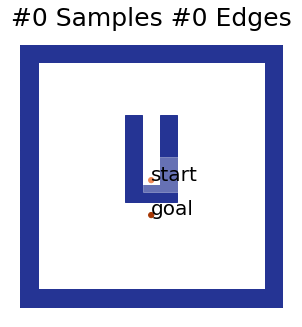

<Figure size 432x288 with 0 Axes>

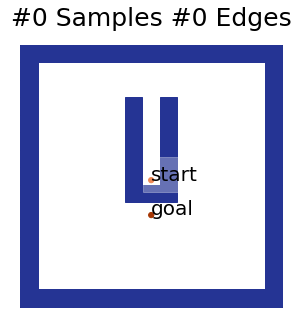

<Figure size 432x288 with 0 Axes>

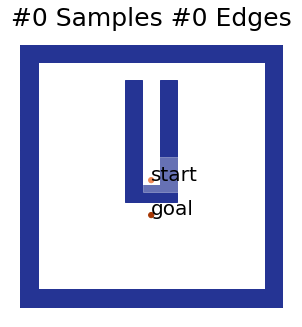

<Figure size 432x288 with 0 Axes>

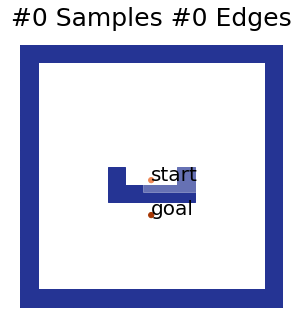

<Figure size 432x288 with 0 Axes>

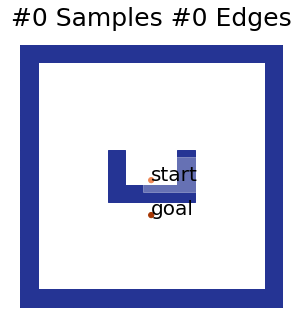

<Figure size 432x288 with 0 Axes>

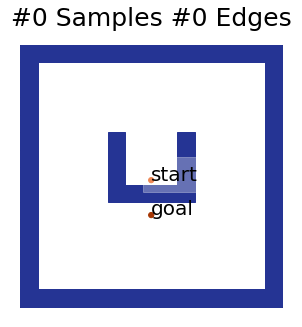

<Figure size 432x288 with 0 Axes>

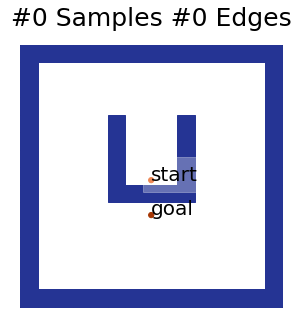

<Figure size 432x288 with 0 Axes>

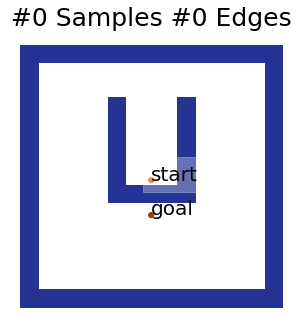

<Figure size 432x288 with 0 Axes>

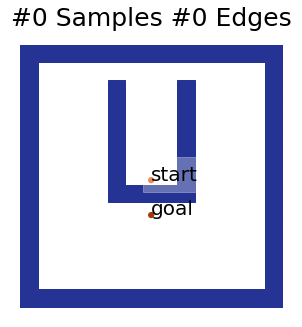

<Figure size 432x288 with 0 Axes>

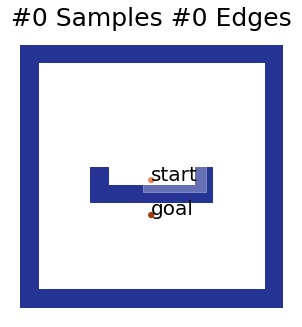

<Figure size 432x288 with 0 Axes>

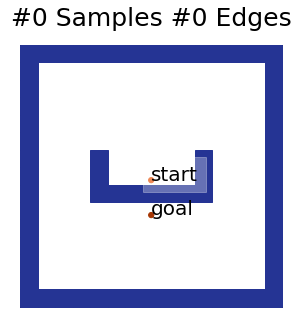

<Figure size 432x288 with 0 Axes>

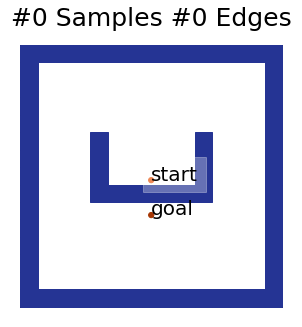

<Figure size 432x288 with 0 Axes>

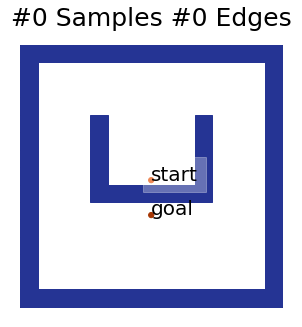

<Figure size 432x288 with 0 Axes>

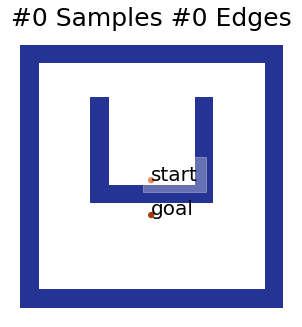

<Figure size 432x288 with 0 Axes>

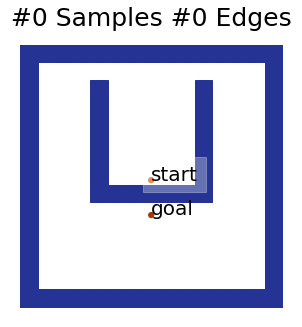

<Figure size 432x288 with 0 Axes>

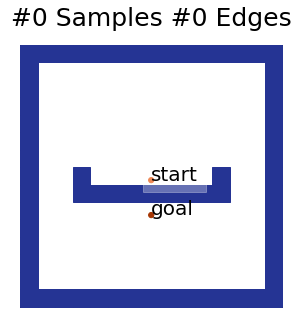

<Figure size 432x288 with 0 Axes>

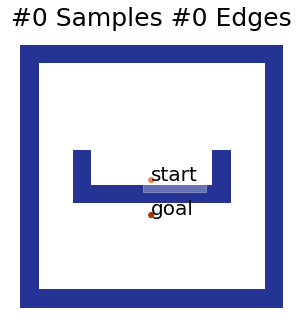

<Figure size 432x288 with 0 Axes>

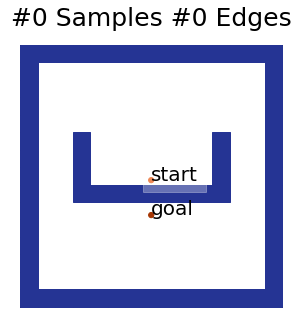

<Figure size 432x288 with 0 Axes>

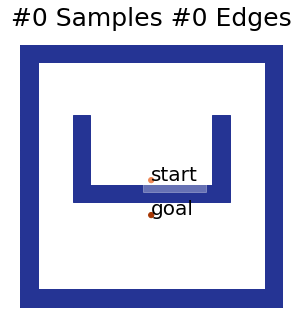

<Figure size 432x288 with 0 Axes>

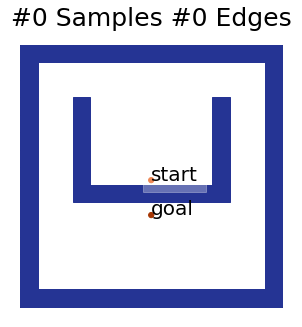

<Figure size 432x288 with 0 Axes>

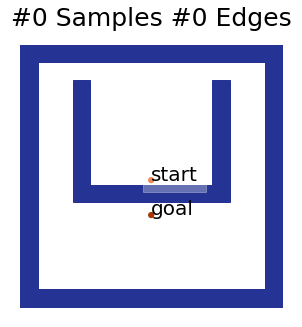

<Figure size 432x288 with 0 Axes>

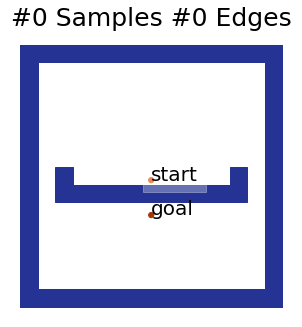

<Figure size 432x288 with 0 Axes>

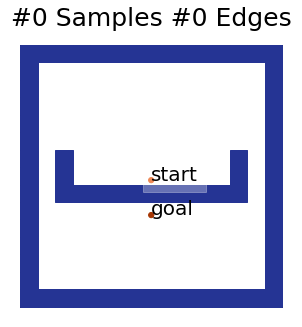

<Figure size 432x288 with 0 Axes>

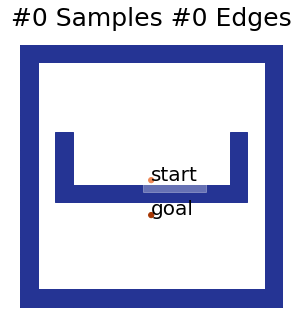

<Figure size 432x288 with 0 Axes>

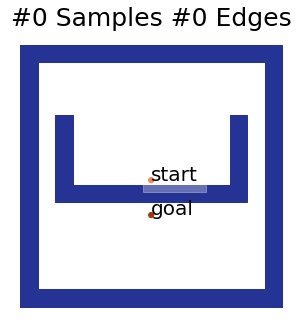

<Figure size 432x288 with 0 Axes>

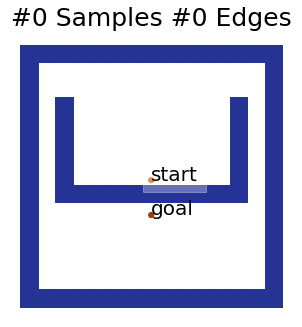

<Figure size 432x288 with 0 Axes>

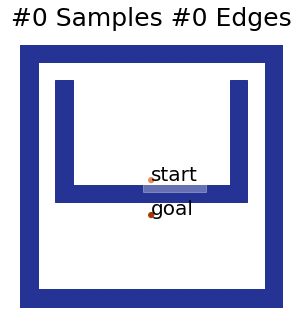

<Figure size 432x288 with 0 Axes>

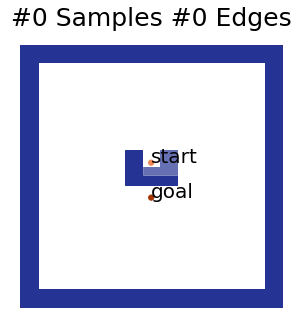

<Figure size 432x288 with 0 Axes>

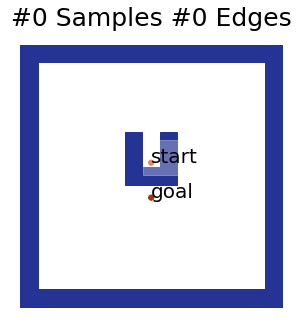

<Figure size 432x288 with 0 Axes>

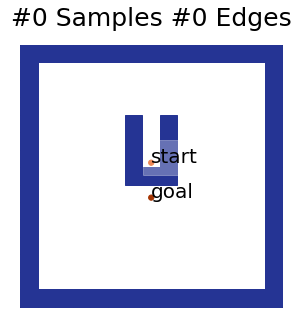

<Figure size 432x288 with 0 Axes>

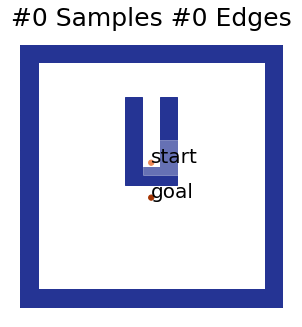

<Figure size 432x288 with 0 Axes>

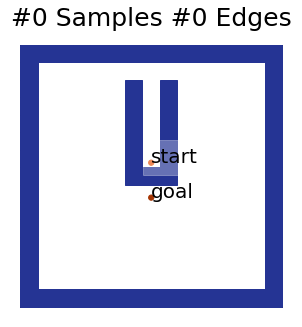

<Figure size 432x288 with 0 Axes>

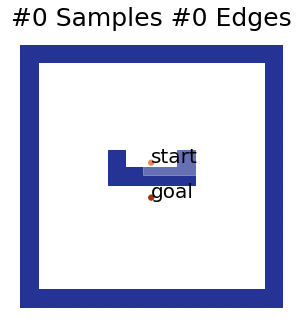

<Figure size 432x288 with 0 Axes>

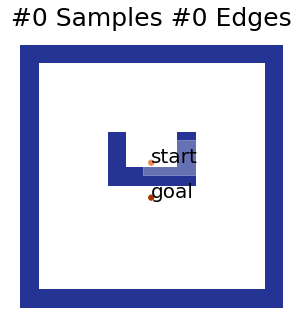

<Figure size 432x288 with 0 Axes>

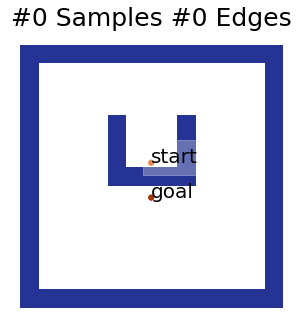

<Figure size 432x288 with 0 Axes>

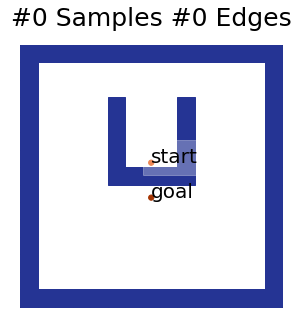

<Figure size 432x288 with 0 Axes>

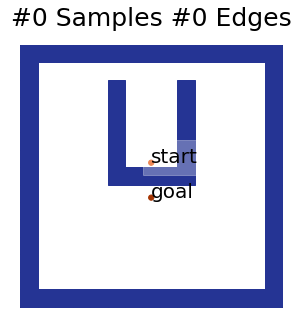

<Figure size 432x288 with 0 Axes>

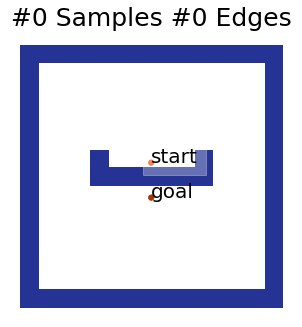

<Figure size 432x288 with 0 Axes>

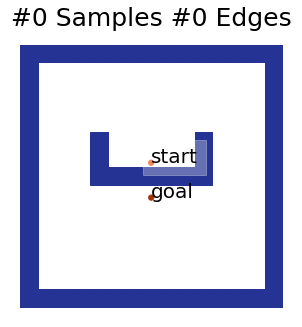

<Figure size 432x288 with 0 Axes>

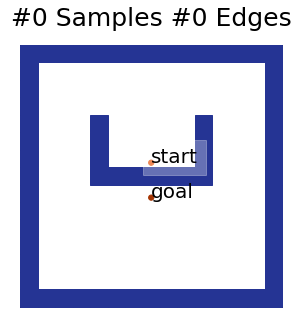

<Figure size 432x288 with 0 Axes>

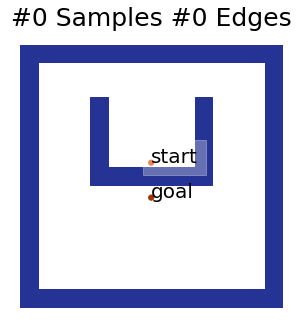

<Figure size 432x288 with 0 Axes>

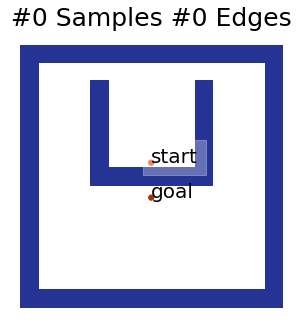

<Figure size 432x288 with 0 Axes>

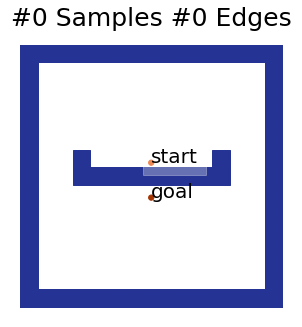

<Figure size 432x288 with 0 Axes>

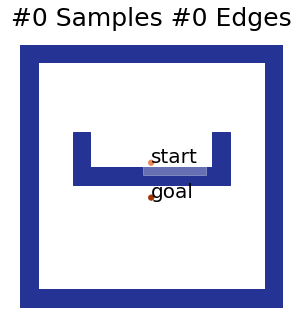

<Figure size 432x288 with 0 Axes>

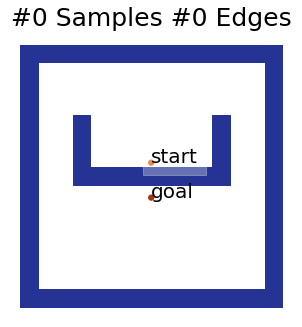

<Figure size 432x288 with 0 Axes>

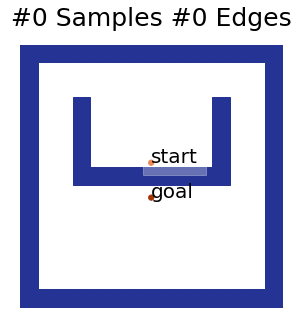

<Figure size 432x288 with 0 Axes>

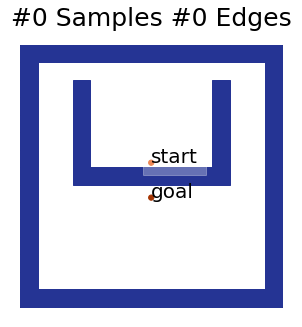

<Figure size 432x288 with 0 Axes>

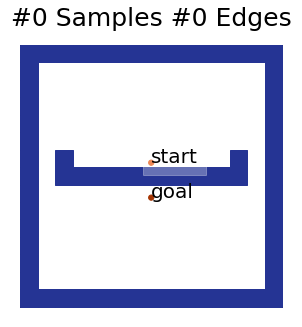

<Figure size 432x288 with 0 Axes>

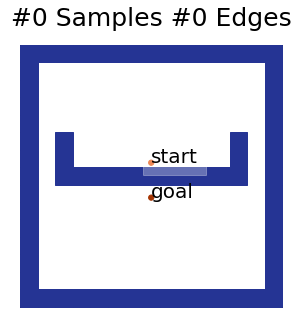

<Figure size 432x288 with 0 Axes>

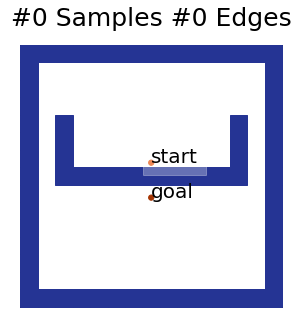

<Figure size 432x288 with 0 Axes>

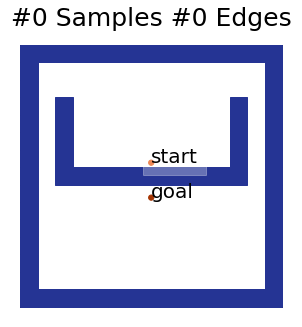

<Figure size 432x288 with 0 Axes>

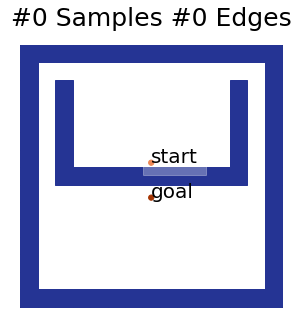

<Figure size 432x288 with 0 Axes>

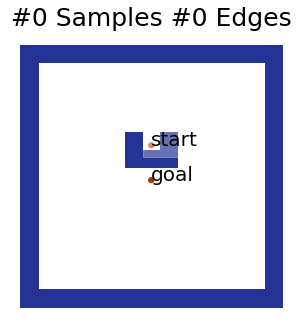

<Figure size 432x288 with 0 Axes>

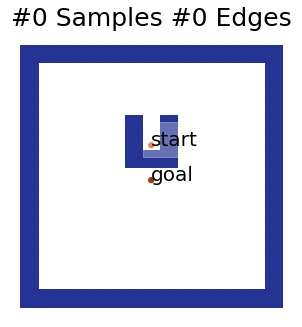

<Figure size 432x288 with 0 Axes>

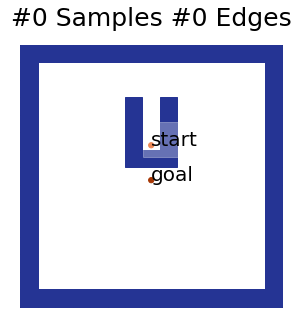

<Figure size 432x288 with 0 Axes>

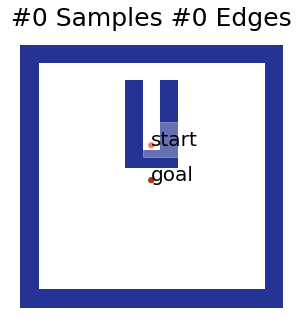

<Figure size 432x288 with 0 Axes>

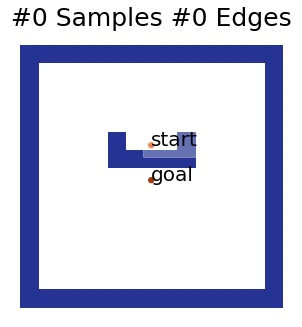

<Figure size 432x288 with 0 Axes>

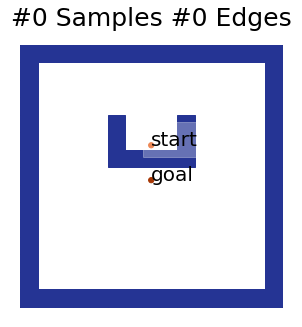

<Figure size 432x288 with 0 Axes>

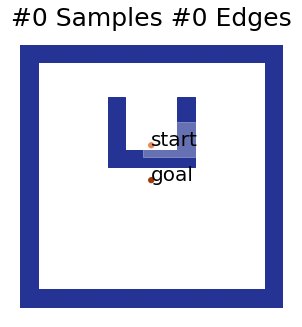

<Figure size 432x288 with 0 Axes>

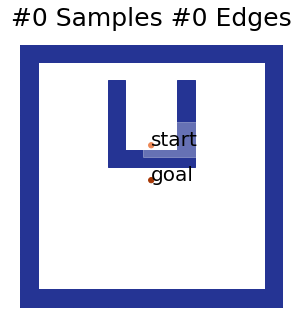

<Figure size 432x288 with 0 Axes>

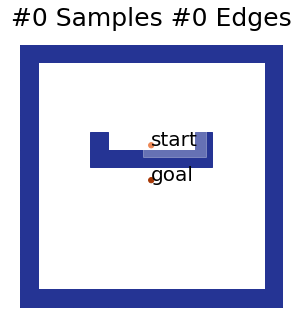

<Figure size 432x288 with 0 Axes>

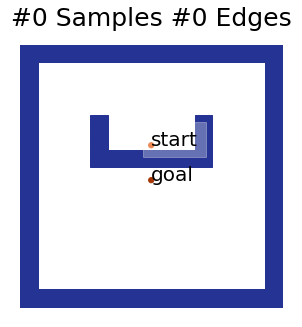

<Figure size 432x288 with 0 Axes>

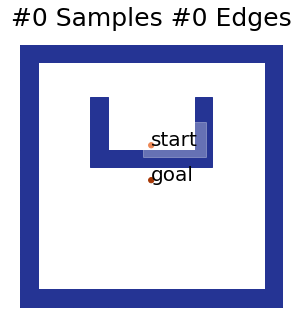

<Figure size 432x288 with 0 Axes>

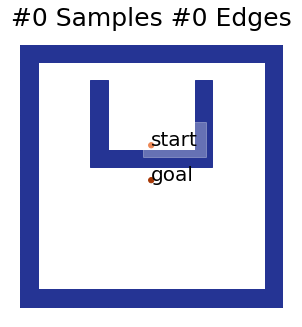

<Figure size 432x288 with 0 Axes>

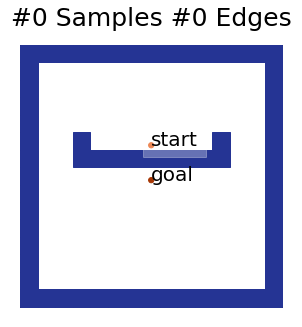

<Figure size 432x288 with 0 Axes>

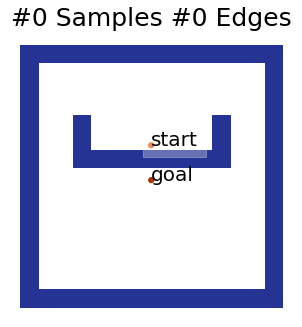

<Figure size 432x288 with 0 Axes>

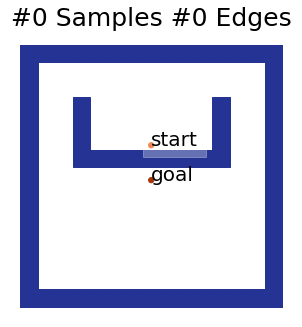

<Figure size 432x288 with 0 Axes>

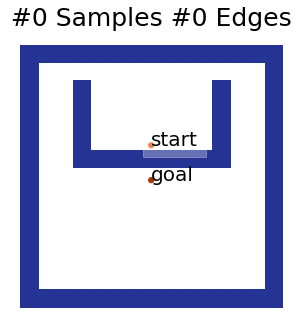

<Figure size 432x288 with 0 Axes>

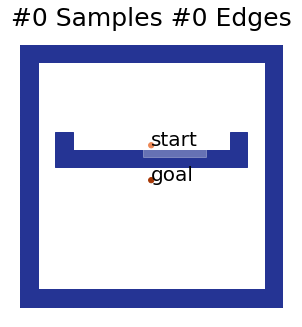

<Figure size 432x288 with 0 Axes>

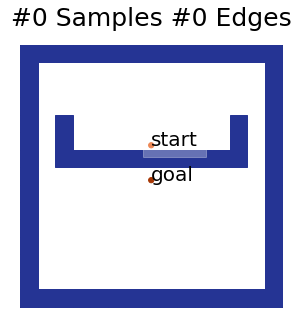

<Figure size 432x288 with 0 Axes>

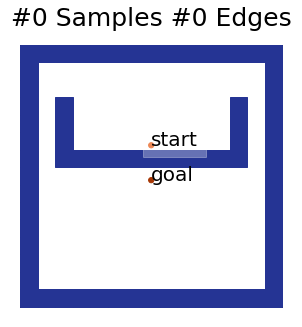

<Figure size 432x288 with 0 Axes>

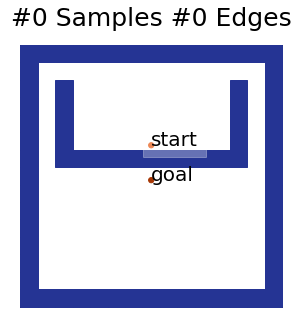

<Figure size 432x288 with 0 Axes>

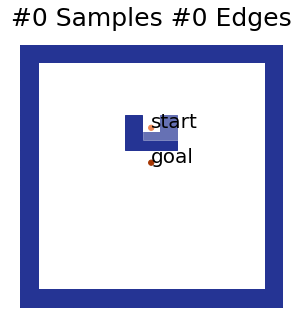

<Figure size 432x288 with 0 Axes>

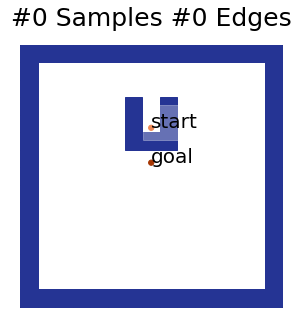

<Figure size 432x288 with 0 Axes>

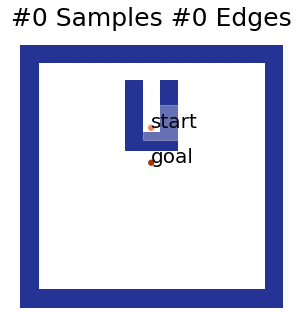

<Figure size 432x288 with 0 Axes>

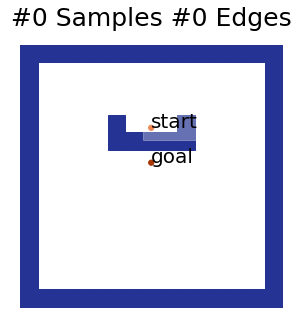

<Figure size 432x288 with 0 Axes>

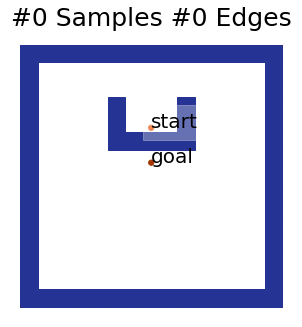

<Figure size 432x288 with 0 Axes>

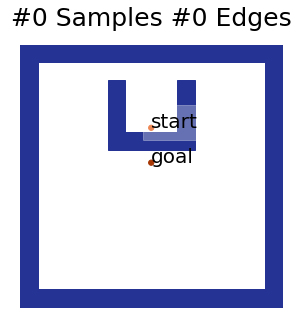

<Figure size 432x288 with 0 Axes>

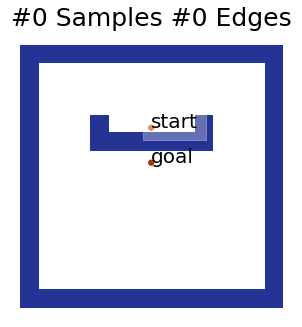

<Figure size 432x288 with 0 Axes>

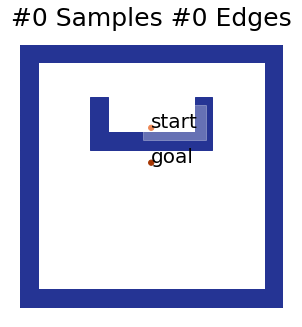

<Figure size 432x288 with 0 Axes>

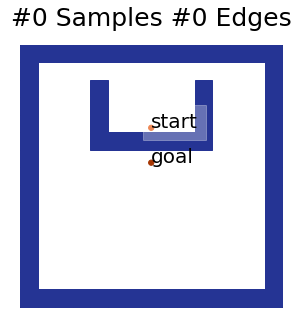

<Figure size 432x288 with 0 Axes>

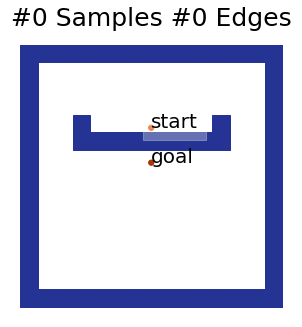

<Figure size 432x288 with 0 Axes>

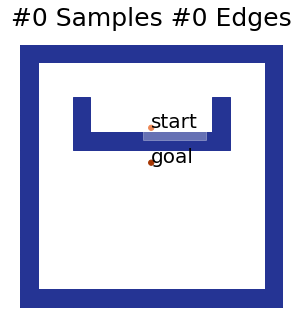

<Figure size 432x288 with 0 Axes>

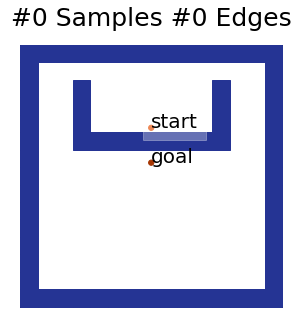

<Figure size 432x288 with 0 Axes>

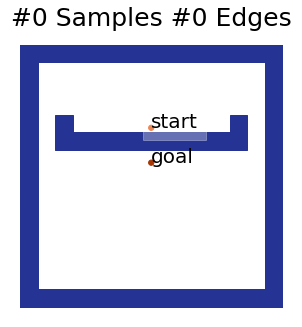

<Figure size 432x288 with 0 Axes>

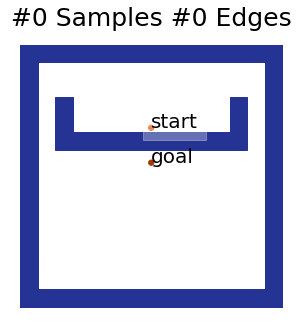

<Figure size 432x288 with 0 Axes>

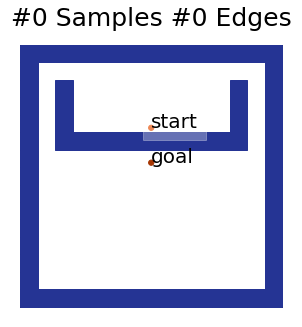

<Figure size 432x288 with 0 Axes>

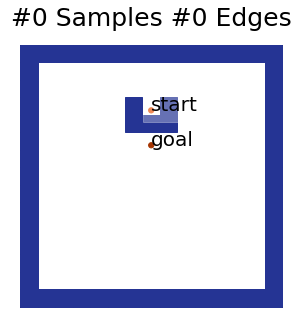

<Figure size 432x288 with 0 Axes>

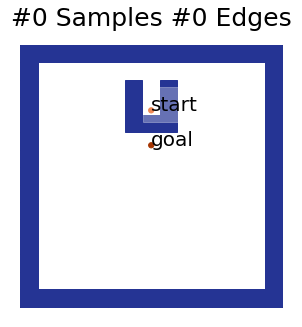

<Figure size 432x288 with 0 Axes>

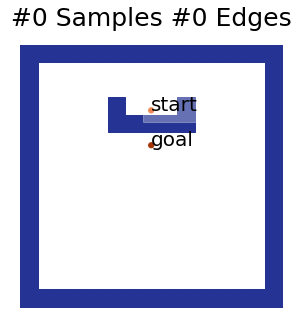

<Figure size 432x288 with 0 Axes>

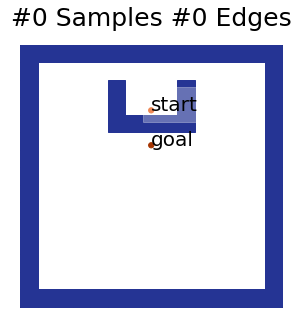

<Figure size 432x288 with 0 Axes>

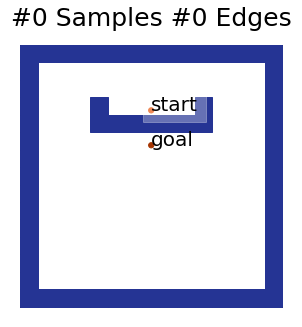

<Figure size 432x288 with 0 Axes>

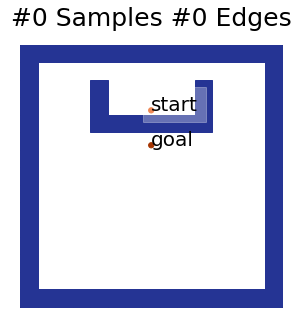

<Figure size 432x288 with 0 Axes>

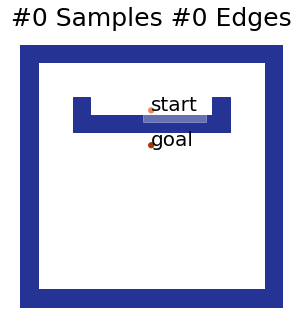

<Figure size 432x288 with 0 Axes>

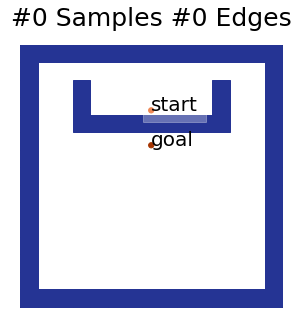

<Figure size 432x288 with 0 Axes>

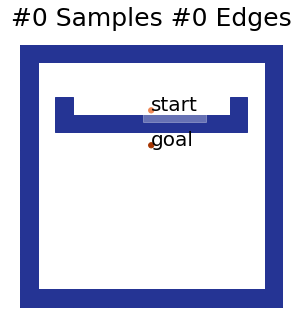

<Figure size 432x288 with 0 Axes>

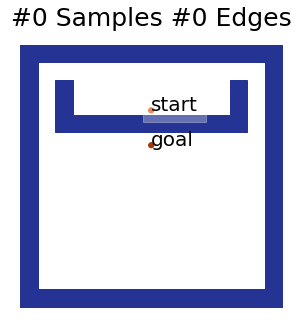

<Figure size 432x288 with 0 Axes>

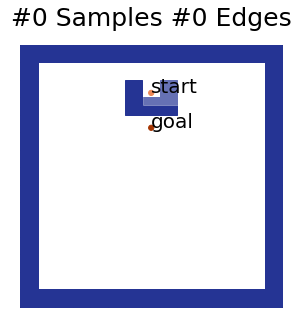

<Figure size 432x288 with 0 Axes>

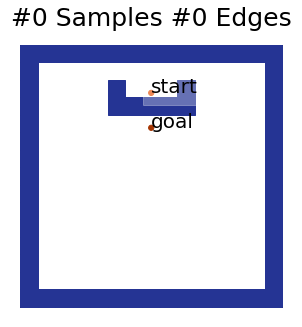

<Figure size 432x288 with 0 Axes>

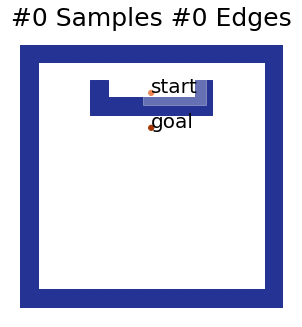

<Figure size 432x288 with 0 Axes>

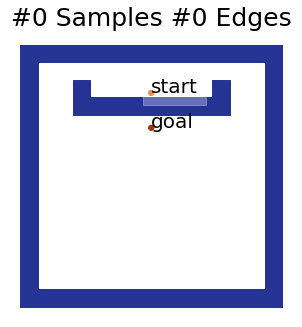

<Figure size 432x288 with 0 Axes>

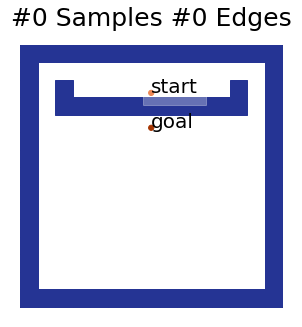

In [12]:
import matplotlib.pyplot as plt
from utils.plot import plot_edges
width = 15
for bottom in range(2, width-2):
    for narrow in range(1, width//2-1):
        for depth in range(1, width-2-bottom):
            map_, start, goal = create_simple_map(bottom, depth, narrow, env, width)
            env.maps[0] = map_
            env.init_new_problem(0)
            env.init_state = np.array(start)
            env.goal_state = np.array(goal)
            plot_edges({}, {}, env.get_problem())
            plt.show()

In [14]:
count = 0
for width in [9, 17, 25, 31, 39]:
    for bottom in range(2, width-2):
        for narrow in range(1, width//2-1):
            for depth in range(1, width-2-bottom):
                count += 1
print(count)

17266


In [77]:
from maze_prm import construct_graph, min_dist, dijkstra, INFINITY
from tqdm import tqdm
from torch_geometric.nn import knn_graph
import torch
from torch_sparse import coalesce
from collections import defaultdict


def create_simple_map(width=15):
    map_ = np.ones((width, width))
    map_[1:-1,1:-1] = 0
    map_[int(width*(9/15)), int(width*(4/15)):int(width*(13/15))] = 1
    map_[int(width*(6/15)), int(width*(4/15)):int(width*(13/15))] = 1
    map_[int(width*(6/15)):int(width*(9/15)+1), int(width*(4/15))] = 1
    start = np.array([-0.,  0-0.25])
    goal = np.array([-0.,  0-0.7])
    return map_, start, goal


def construct_graph(env, free, collided, check_collision=True, k=10):
    k1 = int(np.ceil(k*np.log(len(free))/np.log(100)))
    edge_index_free = knn_graph(torch.FloatTensor(free), k=k1, loop=True)
    edge_index = torch.cat((edge_index_free, edge_index_free.flip(0)), dim=-1)
    edge_index, _ = coalesce(edge_index, None, len(free), len(free))
    edge_index = edge_index.data.cpu().numpy().T
    
    edge_cost = defaultdict(list)
    edge_free = []
    neighbors = defaultdict(list)
    for i, edge in enumerate(edge_index):
        if env._edge_fp(free[edge[0]], free[edge[1]]):
            edge_cost[edge[1]].append(np.linalg.norm(free[edge[1]]-free[edge[0]]))
            edge_free.append(True)
        else:
            edge_cost[edge[1]].append(INFINITY)
            edge_free.append(False)
        neighbors[edge[1]].append(edge[0])
    return edge_cost, neighbors, edge_index, edge_free


data = []
env = MazeEnv(dim=2)

results = []

for problem_index in tqdm(range(2000)):
    while True:
        try:
#             width = 2*np.random.randint(4, 20)+1          
#             bottom = np.random.randint(2, width-2)
#             depth = np.random.randint(1, width-2-bottom)
#             narrow = np.random.randint(1, width//2-1)
#             map_, start, goal = create_simple_map(bottom, depth, narrow, env, width)
            width = np.random.randint(9, 50)
            map_, start, goal = create_simple_map(width)

            env.init_new_problem(0)
            env.init_state = np.array(start)
            env.goal_state = np.array(goal)    

            points = [np.array(start), np.array(goal)]
            n_batch = 400
            free, collided = env.sample_n_points(n_batch, need_negative=True)
            collided = collided[:len(free)]
            free = [env.init_state] + [env.goal_state] + list(free)
            points = list(free) + list(collided)
            
            edge_cost, neighbors, edge_index, edge_free = construct_graph(env, free, collided)

            dist, prev = dijkstra(list(range(len(free))), neighbors, edge_cost, 0)
            if dist[1] != float('inf'):
                break
        except Exception as e:
            print(e)
            continue

    data.append((map_, start, goal, free, collided, neighbors, edge_cost, edge_index, edge_free))

100%|██████████| 2000/2000 [16:54<00:00,  1.97it/s]


In [ ]:
env.maps = env.maps.tolist()
for dat in data:
    map_, start, goal, points, neighbors, edge_cost, edge_index, edge_free = dat
    env.maps[0] = map_
    env.init_new_problem(0)
    env.init_state = np.array(start)
    env.goal_state = np.array(goal)
    plot_edges({}, {}, env.get_problem())
    plt.show()

In [79]:
import pickle
with open('data/pkl/maze_ushape_.pkl', 'wb') as f:
    pickle.dump(data, f, pickle.DEFAULT_PROTOCOL)

# train for Explorer

In [1]:
import torch
import numpy as np
from torch_geometric.data import Data
from config import config, set_random_seed
from tqdm import tqdm as tqdm
from tensorboardX import SummaryWriter
import pickle
from time import time
from algorithm.dijkstra import dijkstra
from str2name import str2name
from torch_geometric.nn import knn_graph
from torch_sparse import coalesce
from eval_gnn import create_data
from train_explorer import device, DotDict, obs_data, explore, policy_data


env, model, _, _, _ = str2name(str='maze2hard')
env.maps = env.maps.tolist()
model_path = 'data/weights/ushape_explorer.pt'

def train_explorer(epoch, model, model_path, env, use_obstacle=True, iter=20, loop=10):

    model.use_obstacle = use_obstacle
    writer = SummaryWriter()
    INFINITY = float('inf')

    set_random_seed(1234)
    model = model.to(device)
    # try:
    #     model.load_state_dict(torch.load(model_path, map_location=device))
    # except:
    #     pass
    data_path = 'data/pkl/maze_ushape_.pkl'
    with open(data_path, 'rb') as f:
        graphs = pickle.load(f)

    T = 0
    losses = []
    loss = 0.
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
    # optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
    optimizer.zero_grad()

    for iter_i in range(iter):
        indexes = np.random.permutation(epoch)
        pbar = tqdm(indexes)
        for index in pbar:
            time0 = time()
            map_, start, goal, free, collided, neighbors, edge_cost, edge_index, edge_free = graphs[index]
            env.maps[0] = map_
            env.init_new_problem(0)
            env.init_state = np.array(start)
            env.goal_state = np.array(goal)
            
            goal_index = 1
            dist, prev = dijkstra(list(range(len(free))), neighbors, edge_cost, goal_index)
            prev[goal_index] = goal_index

            # create data
            data = Data(goal=torch.FloatTensor(env.goal_state))
            data.v = torch.cat((torch.FloatTensor(free),
                                torch.FloatTensor(collided)), dim=0)
            data.labels = torch.zeros(len(data.v), 3)
            data.labels[:len(free), 0] = 1
            data.labels[len(free):, 1] = 1
            data.labels[1, 2] = 1
            k1 = int(np.ceil(10 * np.log(len(free)) / np.log(100)))
            edge_index_free = torch.LongTensor(edge_index.T)
            edge_index = knn_graph(torch.FloatTensor(data.v), k=k1, loop=True)
            edge_index = torch.cat((edge_index, edge_index.flip(0)), dim=-1)
            edge_index = torch.cat((edge_index, edge_index_free), dim=-1)
            data.edge_index, _ = coalesce(edge_index, None, len(data.v), len(data.v))

            time_data = time() - time0

            time0 = time()
            current_loop = np.random.randint(1, loop)
            policy = model(**data.to(device).to_dict(),
                           **obs_data(env, data.v[:len(free)], data.v[len(free):]),
                           loop=current_loop)
            policy = policy[:len(free), :len(free)]
            policy[torch.arange(len(policy)), torch.arange(len(policy))] = 0

            edge_cost_array = np.zeros((len(free), len(free)))
            for x in neighbors:
                for y, cost in zip(neighbors[x], edge_cost[x]):
                    edge_cost_array[x, y] = cost
            start_index = 0
            try:
                step = explore(edge_cost_array, policy.detach().clone(), start_index, goal_index, 1000)
            except Exception:
                continue
                
            next_edge, next_edge_idx, frontier = policy_data(edge_cost_array, dist, prev, policy.detach().clone(),
                                              start_index, goal_index, np.random.randint(0, step+1))
            
            if len(frontier)>1:
                policy_loss = -policy[frontier].log_softmax(dim=0)[next_edge_idx]   # a variant of the cross entropy
            else:
                policy_loss = 0.

            
            edge_loss = torch.nn.BCEWithLogitsLoss()(policy[policy!=0], 
                                                     torch.BoolTensor(edge_cost_array[policy.cpu().data.numpy()!=0]!=float('inf')).float().to(device))
            
#             if use_obstacle:
#                 loss = value_loss + policy_loss + node_loss + edge_loss
#             else:
            new_loss = policy_loss
            loss += new_loss
            # loss = policy_loss
            losses.append((new_loss, 0, policy_loss, 0, edge_loss))
            time_train = time() - time0

            time0 = time()
            if (T % 8 == 0) and (T != 0):
                loss = loss / len(losses)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss, value_loss, policy_loss, node_loss, edge_loss = \
                    [sum([loss[i] for loss in losses]) / len(losses) for i in range(5)]

                writer.add_scalar('train/total_loss', total_loss, T)
                writer.add_scalar('train/value_loss', value_loss, T)
                writer.add_scalar('train/policy_loss', policy_loss, T)
                writer.add_scalar('train/node_loss', node_loss, T)
                writer.add_scalar('train/edge_loss', edge_loss, T)

                pbar.set_description("total %.2f, value %.2f, policy %.2f, node %.2f, edge %.2f" \
                                     % (total_loss, value_loss, policy_loss, node_loss, edge_loss))

                losses = []
                loss = 0.

                torch.save(model.state_dict(), model_path)

            T += 1
            # time_bp = time() - time0
            #
            # pbar.set_description("data %.2fs, train %.2fs, bp %.2fs, value std: %.2f" \
            #                      % (time_data, time_train, time_bp, value.std()))

    torch.save(model.state_dict(), model_path)
    writer.close()

In [2]:
train_explorer(2000, model, model_path, env, iter=40, use_obstacle=False)

total 1.36, value 0.00, policy 1.36, node 0.00, edge 5.12: 100%|██████████| 2000/2000 [01:41<00:00, 19.66it/s]
total 0.87, value 0.00, policy 0.87, node 0.00, edge 5.75: 100%|██████████| 2000/2000 [01:34<00:00, 21.24it/s]
total 1.02, value 0.00, policy 1.02, node 0.00, edge 7.27: 100%|██████████| 2000/2000 [01:33<00:00, 21.49it/s] 
total 0.18, value 0.00, policy 0.18, node 0.00, edge 17.17: 100%|██████████| 2000/2000 [01:33<00:00, 21.50it/s]
total 0.35, value 0.00, policy 0.35, node 0.00, edge 5.41: 100%|██████████| 2000/2000 [01:34<00:00, 21.07it/s]
total 0.23, value 0.00, policy 0.23, node 0.00, edge 7.89: 100%|██████████| 2000/2000 [01:33<00:00, 21.40it/s]
total 0.77, value 0.00, policy 0.77, node 0.00, edge 10.53: 100%|██████████| 2000/2000 [01:34<00:00, 21.18it/s]
total 0.69, value 0.00, policy 0.69, node 0.00, edge 8.08: 100%|██████████| 2000/2000 [01:33<00:00, 21.31it/s] 
total 0.09, value 0.00, policy 0.09, node 0.00, edge 16.91: 100%|██████████| 2000/2000 [01:33<00:00, 21.32it

RuntimeError: CUDA out of memory. Tried to allocate 474.00 MiB (GPU 0; 7.79 GiB total capacity; 1.72 GiB already allocated; 254.12 MiB free; 5.96 GiB reserved in total by PyTorch)

In [54]:
%debug

> <ipython-input-52-b41eb008fe60>(61)train_explorer()
     59             data = Data(goal=torch.FloatTensor(env.goal_state))
     60             data.v = torch.cat((torch.FloatTensor(free),
---> 61                                 torch.FloatTensor(collided)), dim=0)
     62             data.labels = torch.zeros(len(data.v), 3)
     63             data.labels[:len(free), 0] = 1



ipdb>  exit()


In [3]:
model.load_state_dict(torch.load('data/weights/ushape_explorer_10231617.pt'))

<All keys matched successfully>

In [4]:
batch = 400
def plan_gnn(env):
    set_random_seed(seed)
#     _, model, model_path, _, _ = str2name('maze2hard')
#     model.load_state_dict(torch.load('data/weights/ushape_explorer.pt', map_location=torch.device("cpu")))
    _, _, _, model_s, model_s_path = str2name('maze2hard')
    model_s.load_state_dict(torch.load(model_s_path, map_location=torch.device("cpu")))
    model.eval()
    model_s.eval()
    result = explore(env, model, model_s, smooth=True, batch=batch, t_max=batch, k=10, loop=10) 
    return result

def plan_sp(env):
    set_random_seed(seed)
    lazysp = LazySP(env, batch_size=batch, T=batch)
    result_sp = lazysp.plan()
    return result_sp

In [ ]:
from algorithm.lazy_sp import LazySP
from config import set_random_seed
from eval_gnn import explore
from str2name import str2name
import torch

env, indexes = str2env('maze2hard')
env.maps = env.maps.tolist()
def create_simple_map(width=15):
    map_ = np.ones((width, width))
    map_[1:-1,1:-1] = 0
    map_[int(width*(9/15)), int(width*(4/15)):int(width*(13/15))] = 1
    map_[int(width*(6/15)), int(width*(4/15)):int(width*(13/15))] = 1
    map_[int(width*(6/15)):int(width*(9/15)+1), int(width*(4/15))] = 1
    return map_

thinnesses = [9, 13, 17, 21, 25, 29, 31, 35, 39, 43]

for seed in [1234, 2341, 3412, 4123]:
    for width in thinnesses:
        seed_ = seed
        env.maps[0] = create_simple_map(width=width)
        env.init_new_problem(0)
        env.goal_state = np.array([-0.,  0-0.7])
        env.init_state = np.array([-0.,  0-0.25])
        plot_edges({}, {}, env.get_problem())

        for _ in range(10):
            seed = np.random.randint(100)
            result_sp = plan_sp(env)
            result_gnn = plan_gnn(env)
            print('width {0:d}, gnn collision {1:d}, lazy collision {2:d}'.format(width, result_gnn['c_explore'], result_sp[1]))
            seed = seed_
            plot(result_sp, result_gnn, env)
            plt.clf()
            if len(result_sp[2])!=0:
                break

802
1063
width 9, gnn collision 1063, lazy collision 897
662
1020
width 13, gnn collision 1020, lazy collision 989
587
966
width 17, gnn collision 966, lazy collision 951
545
1054
width 21, gnn collision 1054, lazy collision 1007
487
952
width 25, gnn collision 952, lazy collision 1031
475
1076
width 29, gnn collision 1076, lazy collision 991
484
1003
width 31, gnn collision 1003, lazy collision 1024
471
1102
width 35, gnn collision 1102, lazy collision 1186
458
1248
width 39, gnn collision 1248, lazy collision 1234
452
1167
width 43, gnn collision 1167, lazy collision 1077
843
1068
width 9, gnn collision 1068, lazy collision 995
653
1049
width 13, gnn collision 1049, lazy collision 1039
575
949
width 17, gnn collision 949, lazy collision 996
550
958
width 21, gnn collision 958, lazy collision 954
494
1014
width 25, gnn collision 1014, lazy collision 988
494
1075
width 29, gnn collision 1075, lazy collision 1132
486
1043
width 31, gnn collision 1043, lazy collision 1054
489
1138
width 

In [71]:
for seed in [1234, 2341, 3412, 4123]:
    image_paths = ['data/images/{0:d}_{1:d}_{2:s}.png'.format(seed, width, method) for width in thinnesses for method in ['lazy', 'gnn']]
    merge_pic(image_paths, 2, len(image_paths)//2, 'data/images/{0:d}_lazy_gnn.png'.format(seed))
merge_pic(['data/images/{0:d}_lazy_gnn.png'.format(seed) for seed in [1234, 2341, 3412, 4123]], 4, 1, 'data/images/new_model_narrow_deep.png')    